In [21]:
import kagglehub
import os
import shutil
import pandas as pd
import seaborn as sns
import kaggle
import numpy as np

In [45]:

# Download latest version
kaggle.api.dataset_download_files(dataset="abrambeyer/openintro-possum", path="./", unzip=True)

print("Data download complete.")

Dataset URL: https://www.kaggle.com/datasets/abrambeyer/openintro-possum
Data download complete.


In [3]:
df = pd.read_csv('possum.csv')
df.drop('Pop', axis=1, inplace=True)
df.drop('case', axis=1, inplace=True)
df.drop('sex', axis=1, inplace=True)

In [4]:
df.head()

,site,age,hdlngth,skullw,totlngth,taill,footlgth,earconch,eye,chest,belly
0,1,8.0,94.1,60.4,89.0,36.0,74.5,54.5,15.2,28.0,36.0
1,1,6.0,92.5,57.6,91.5,36.5,72.5,51.2,16.0,28.5,33.0
2,1,6.0,94.0,60.0,95.5,39.0,75.4,51.9,15.5,30.0,34.0
3,1,6.0,93.2,57.1,92.0,38.0,76.1,52.2,15.2,28.0,34.0
4,1,2.0,91.5,56.3,85.5,36.0,71.0,53.2,15.1,28.5,33.0


In [5]:
from sklearn.model_selection import train_test_split

# Спочатку розділяємо на train (70%) і temp (30%)
train_df, temp_df = train_test_split(df, test_size=0.3, random_state=42)

# Потім розділяємо temp (30%) на validation (15%) і test (15%)
val_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=42)

print(f"Тренувальна вибірка: {len(train_df)} ({len(train_df)/len(df)*100:.1f}%)")
print(f"Валідаційна вибірка: {len(val_df)} ({len(val_df)/len(df)*100:.1f}%)")
print(f"Тестова вибірка: {len(test_df)} ({len(test_df)/len(df)*100:.1f}%)")
print(f"\nЗагальна кількість: {len(train_df) + len(val_df) + len(test_df)}")

print("Age mean in train:", train_df.age.mean())
print("Age mean in val:", val_df.age.mean())
print("Age mean in test:", test_df.age.mean())

Тренувальна вибірка: 72 (69.2%)
Валідаційна вибірка: 16 (15.4%)
Тестова вибірка: 16 (15.4%)

Загальна кількість: 104
Age mean in train: 3.704225352112676
Age mean in val: 3.8125
Age mean in test: 4.466666666666667


In [6]:
# Перевіримо наявність NaN значень
print("Кількість NaN значень у кожному стовпці train:\n")
print(train_df.isnull().sum())

all_train_means = train_df.mean(numeric_only=True)

print("Розраховані середні з train_df:")
print(all_train_means)
print("-" * 30)

# 2. Заповнюємо NaN у всіх наборах, використовуючи ці середні
# .fillna() використає правильне середнє для правильної колонки.
train_df = train_df.fillna(value=all_train_means)
val_df = val_df.fillna(value=all_train_means)
test_df = test_df.fillna(value=all_train_means)

print("NaNs заповнено.")

print("Кількість NaN значень у кожному стовпці train:\n")
print(train_df.isnull().sum())


Кількість NaN значень у кожному стовпці train:

site        0
age         1
hdlngth     0
skullw      0
totlngth    0
taill       0
footlgth    0
earconch    0
eye         0
chest       0
belly       0
dtype: int64
Розраховані середні з train_df:
site         3.750000
age          3.704225
hdlngth     92.691667
skullw      56.991667
totlngth    87.270833
taill       37.215278
footlgth    68.195833
earconch    48.055556
eye         15.068056
chest       26.944444
belly       32.548611
dtype: float64
------------------------------
NaNs заповнено.
Кількість NaN значень у кожному стовпці train:

site        0
age         0
hdlngth     0
skullw      0
totlngth    0
taill       0
footlgth    0
earconch    0
eye         0
chest       0
belly       0
dtype: int64


## Нормалізація числових даних

Нормалізуємо числові ознаки (включаючи закодовані категоріальні) за формулою: `(x - mean) / std`

**Важливо:** Mean та std розраховуються **тільки на тренувальних даних** і застосовуються до всіх трьох вибірок для уникнення data leakage.

In [7]:
for col in train_df.columns:
    print(f"{col}: {train_df[col].dtype}")

site: int64
age: float64
hdlngth: float64
skullw: float64
totlngth: float64
taill: float64
footlgth: float64
earconch: float64
eye: float64
chest: float64
belly: float64


In [8]:
# Створимо копії DataFrame для збереження оригінальних даних
train_normalized = train_df.copy()
val_normalized = val_df.copy()
test_normalized = test_df.copy()

# Визначимо числові колонки (виключаємо категоріальні)
numeric_features = train_df.select_dtypes(include=['float64', 'int64']).columns.tolist()

print("Числові ознаки для нормалізації:", numeric_features)

# Обраховуємо mean та std ТІЛЬКИ на тренувальних даних
normalization_params = {}
for col in numeric_features:
    mean_val = train_df[col].mean()
    std_val = train_df[col].std()
    normalization_params[col] = {'mean': mean_val, 'std': std_val}
    
    print(f"\n{col}:")
    print(f"  Mean: {mean_val:.4f}")
    print(f"  Std:  {std_val:.4f}")

Числові ознаки для нормалізації: ['site', 'age', 'hdlngth', 'skullw', 'totlngth', 'taill', 'footlgth', 'earconch', 'eye', 'chest', 'belly']

site:
  Mean: 3.7500
  Std:  2.3301

age:
  Mean: 3.7042
  Std:  1.8492

hdlngth:
  Mean: 92.6917
  Std:  3.6402

skullw:
  Mean: 56.9917
  Std:  3.2926

totlngth:
  Mean: 87.2708
  Std:  4.5556

taill:
  Mean: 37.2153
  Std:  1.9261

footlgth:
  Mean: 68.1958
  Std:  4.4695

earconch:
  Mean: 48.0556
  Std:  4.0394

eye:
  Mean: 15.0681
  Std:  1.0505

chest:
  Mean: 26.9444
  Std:  2.1089

belly:
  Mean: 32.5486
  Std:  2.8435


In [10]:
# Застосовуємо нормалізацію: (x - mean) / std
for col in numeric_features:
    mean_val = normalization_params[col]['mean']
    std_val = normalization_params[col]['std']
    
    # Нормалізуємо всі три вибірки використовуючи параметри з train
    train_normalized[col] = (train_df[col] - mean_val) / std_val
    val_normalized[col] = (val_df[col] - mean_val) / std_val
    test_normalized[col] = (test_df[col] - mean_val) / std_val

print("✓ Нормалізація завершена")
print(f"\nПеревірка нормалізованих тренувальних даних:")
print(f"Mean age (має бути ~0): {train_normalized['age'].mean():.6f}")
print(f"Std age (має бути ~1): {train_normalized['age'].std():.6f}")

✓ Нормалізація завершена

Перевірка нормалізованих тренувальних даних:
Mean age (має бути ~0): 0.000000
Std age (має бути ~1): 1.000000


In [11]:
# Порівняємо оригінальні та нормалізовані дані
print("Приклад нормалізації (перші 3 рядки):\n")
print("ОРИГІНАЛЬНІ ДАНІ:")
print(train_df[numeric_features].head(3))
print("\nНОРМАЛІЗОВАНІ ДАНІ:")
print(train_normalized[numeric_features].head(3))

Приклад нормалізації (перші 3 рядки):

ОРИГІНАЛЬНІ ДАНІ:
     site  age  hdlngth  skullw  totlngth  taill  footlgth  earconch   eye  \
103     7  3.0     93.6    59.9      89.0   40.0      67.6      46.0  14.8   
78      6  1.0     85.8    50.0      81.0   36.5      62.8      43.0  14.8   
28      1  3.0     92.8    56.0      88.0   35.0      74.9      51.8  14.0   

     chest  belly  
103   28.5   33.5  
78    22.0   28.5  
28    24.0   32.0  

НОРМАЛІЗОВАНІ ДАНІ:
         site       age   hdlngth    skullw  totlngth     taill  footlgth  \
103  1.394763 -0.380826  0.249530  0.883289  0.379573  1.445747 -0.133310   
78   0.965605 -1.462372 -1.893221 -2.123436 -1.376525 -0.371351 -1.207247   
28  -1.180184 -0.380826  0.029760 -0.301179  0.160061 -1.150108  1.499970   

     earconch       eye     chest     belly  
103 -0.508870 -0.255162  0.737605  0.334581  
78  -1.251546 -0.255162 -2.344531 -1.423800  
28   0.926969 -1.016683 -1.396181 -0.192933  


## Частина 2. Побудова дерев рішень

Побудуємо 3 різні дерева рішень з різною глибиною:
- **Дерево 1**: max_depth = 3 (мале дерево)
- **Дерево 2**: max_depth = 10 (середнє дерево)
- **Дерево 3**: max_depth = None (без обмежень)

In [12]:
# Підготуємо дані для навчання моделей
# Відокремимо ознаки (X) від цільової змінної (y)

X_train = train_normalized.drop('age', axis=1)
y_train = train_normalized['age']

X_val = val_normalized.drop('age', axis=1)
y_val = val_normalized['age']

X_test = test_normalized.drop('age', axis=1)
y_test = test_normalized['age']

print("Форма тренувальних даних:")
print(f"  X_train: {X_train.shape}")
print(f"  y_train: {y_train.shape}")
print(f"\nФорма валідаційних даних:")
print(f"  X_val: {X_val.shape}")
print(f"  y_val: {y_val.shape}")
print(f"\nФорма тестових даних:")
print(f"  X_test: {X_test.shape}")
print(f"  y_test: {y_test.shape}")

print(f"\nНазви ознак ({len(X_train.columns)}):")
print(list(X_train.columns))

Форма тренувальних даних:
  X_train: (72, 10)
  y_train: (72,)

Форма валідаційних даних:
  X_val: (16, 10)
  y_val: (16,)

Форма тестових даних:
  X_test: (16, 10)
  y_test: (16,)

Назви ознак (10):
['site', 'hdlngth', 'skullw', 'totlngth', 'taill', 'footlgth', 'earconch', 'eye', 'chest', 'belly']


In [24]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, root_mean_squared_error, r2_score
import time

# Створимо три дерева з різною глибиною
trees = {
    'Дерево 1 (depth=2)': DecisionTreeRegressor(max_depth=2, random_state=42),
    'Дерево 2 (depth=3)': DecisionTreeRegressor(max_depth=3, random_state=42),
    'Дерево 3 (depth=4)': DecisionTreeRegressor(max_depth=4, random_state=42)
}

# Навчимо моделі та збережемо результати
results = {}

print("=" * 80)
print("НАВЧАННЯ ДЕРЕВ РІШЕНЬ")
print("=" * 80)

for name, model in trees.items():
    print(f"\n{name}")
    print("-" * 80)
    
    # Вимірюємо час навчання
    start_time = time.time()
    model.fit(X_train, y_train)
    training_time = time.time() - start_time
    
    # Передбачення на тренувальній та валідаційній вибірках
    y_train_pred = model.predict(X_train)
    y_val_pred = model.predict(X_val)
    
    # Обчислюємо точність
    train_accuracy_mae = mean_absolute_error(y_train, y_train_pred)
    val_accuracy_mae = mean_absolute_error(y_val, y_val_pred)
    train_accuracy_mse = mean_squared_error(y_train, y_train_pred)
    val_accuracy_mse = mean_squared_error(y_val, y_val_pred)
    train_accuracy_rmse = root_mean_squared_error(y_train, y_train_pred)
    val_accuracy_rmse = root_mean_squared_error(y_val, y_val_pred)
    train_r2 = r2_score(y_train, y_train_pred)
    val_r2 = r2_score(y_val, y_val_pred)
    
    # Зберігаємо результати
    results[name] = {
        'model': model,
        'train_accuracy_mae': train_accuracy_mae,
        'train_accuracy_mse': train_accuracy_mse,
        'train_accuracy_rmse': train_accuracy_rmse,
        'train_r2': train_r2,
        'val_accuracy_mae': val_accuracy_mae,
        'val_accuracy_mse': val_accuracy_mse,
        'val_accuracy_rmse': val_accuracy_rmse,
        'val_r2': val_r2,
        'training_time': training_time,
        'depth': model.get_depth(),
        'n_leaves': model.get_n_leaves()
    }
    
    print(f"  Час навчання: {training_time:.4f} сек")
    print(f"  Фактична глибина дерева: {model.get_depth()}")
    print(f"  Кількість листків: {model.get_n_leaves()}")
    print(f"  Точність тренування MAE: {train_accuracy_mae:.4f}")
    print(f"  Точність валідації MAE: {val_accuracy_mae:.4f}")
    print(f"  Точність тренування MSE: {train_accuracy_mse:.4f}")
    print(f"  Точність валідації MSE: {val_accuracy_mse:.4f}")
    print(f"  Точність тренування RMSE: {train_accuracy_rmse:.4f}")
    print(f"  Точність валідації RMSE: {val_accuracy_rmse:.4f}")
    print(f"  Точність тренування R2: {train_r2:.4f}")
    print(f"  Точність валідації R2: {val_r2:.4f}")


print("\n" + "=" * 80)

НАВЧАННЯ ДЕРЕВ РІШЕНЬ

Дерево 1 (depth=2)
--------------------------------------------------------------------------------
  Час навчання: 0.0030 сек
  Фактична глибина дерева: 2
  Кількість листків: 4
  Точність тренування MAE: 0.6584
  Точність валідації MAE: 0.4905
  Точність тренування MSE: 0.6510
  Точність валідації MSE: 0.4107
  Точність тренування RMSE: 0.8068
  Точність валідації RMSE: 0.6408
  Точність тренування R2: 0.3399
  Точність валідації R2: 0.4154

Дерево 2 (depth=3)
--------------------------------------------------------------------------------
  Час навчання: 0.0020 сек
  Фактична глибина дерева: 3
  Кількість листків: 7
  Точність тренування MAE: 0.5653
  Точність валідації MAE: 0.6778
  Точність тренування MSE: 0.5204
  Точність валідації MSE: 0.6386
  Точність тренування RMSE: 0.7214
  Точність валідації RMSE: 0.7991
  Точність тренування R2: 0.4723
  Точність валідації R2: 0.0910

Дерево 3 (depth=4)
--------------------------------------------------------------

In [25]:
# Створимо порівняльну таблицю результатів
comparison_data = []
for name, res in results.items():
    comparison_data.append({
        'name': name,
        'train_accuracy_mae': res['train_accuracy_mae'],
        'train_accuracy_mse': res['train_accuracy_mse'],
        'train_accuracy_rmse': res['train_accuracy_rmse'],
        'train_r2': res['train_r2'],
        'val_accuracy_mae': res['val_accuracy_mae'],
        'val_accuracy_mse': res['val_accuracy_mse'],
        'val_accuracy_rmse': res['val_accuracy_rmse'],
        'val_r2': res['val_r2'],
    })

comparison_df = pd.DataFrame(comparison_data)
print("\n=== ПОРІВНЯЛЬНА ТАБЛИЦЯ РЕЗУЛЬТАТІВ ===\n")
print(comparison_df.to_string(index=False))


=== ПОРІВНЯЛЬНА ТАБЛИЦЯ РЕЗУЛЬТАТІВ ===

              name  train_accuracy_mae  train_accuracy_mse  train_accuracy_rmse  train_r2  val_accuracy_mae  val_accuracy_mse  val_accuracy_rmse    val_r2
Дерево 1 (depth=2)            0.658397            0.650978             0.806832  0.339853          0.490545          0.410668           0.640834  0.415444
Дерево 2 (depth=3)            0.565259            0.520386             0.721378  0.472285          0.677829          0.638589           0.799117  0.091016
Дерево 3 (depth=4)            0.424872            0.362624             0.602183  0.632269          0.750521          1.029881           1.014830 -0.465960


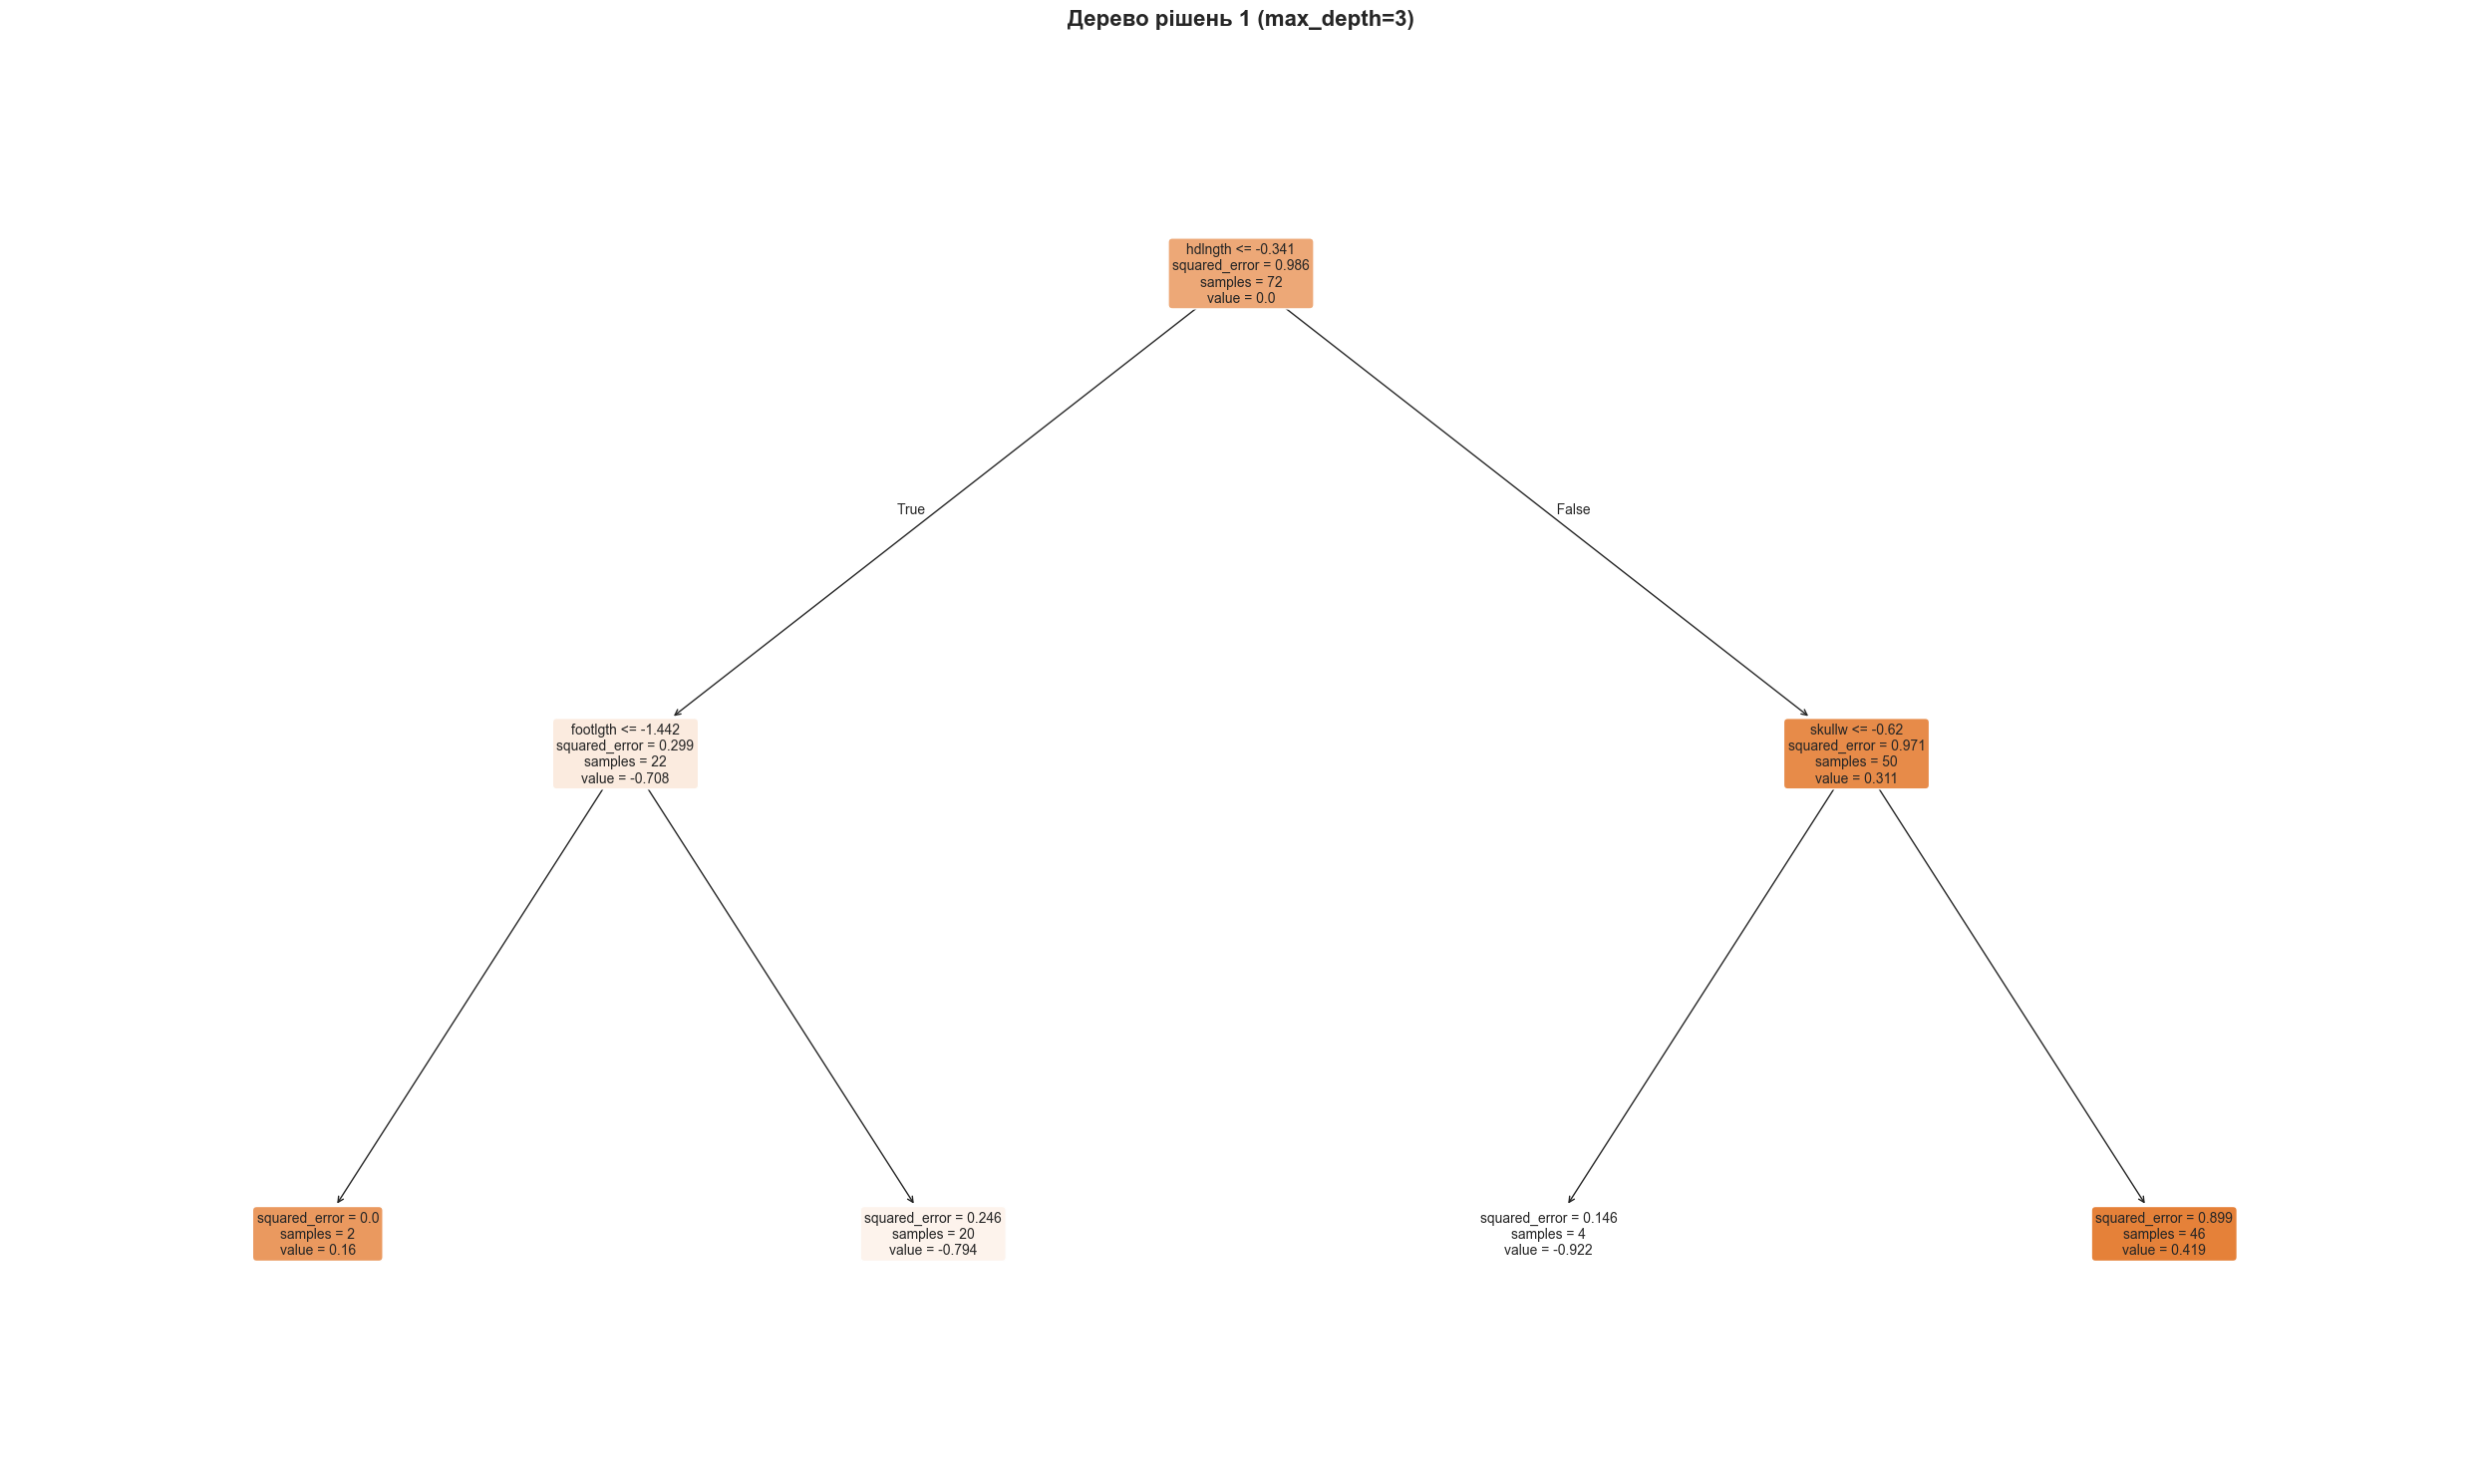

In [27]:
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt

# Візуалізація першого дерева (depth=3)
plt.figure(figsize=(25, 15))
plot_tree(results['Дерево 1 (depth=2)']['model'],
          feature_names=X_train.columns,
          class_names=sorted(y_train.unique()),
          filled=True,
          rounded=True,
          fontsize=10)
plt.title('Дерево рішень 1 (max_depth=3)', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

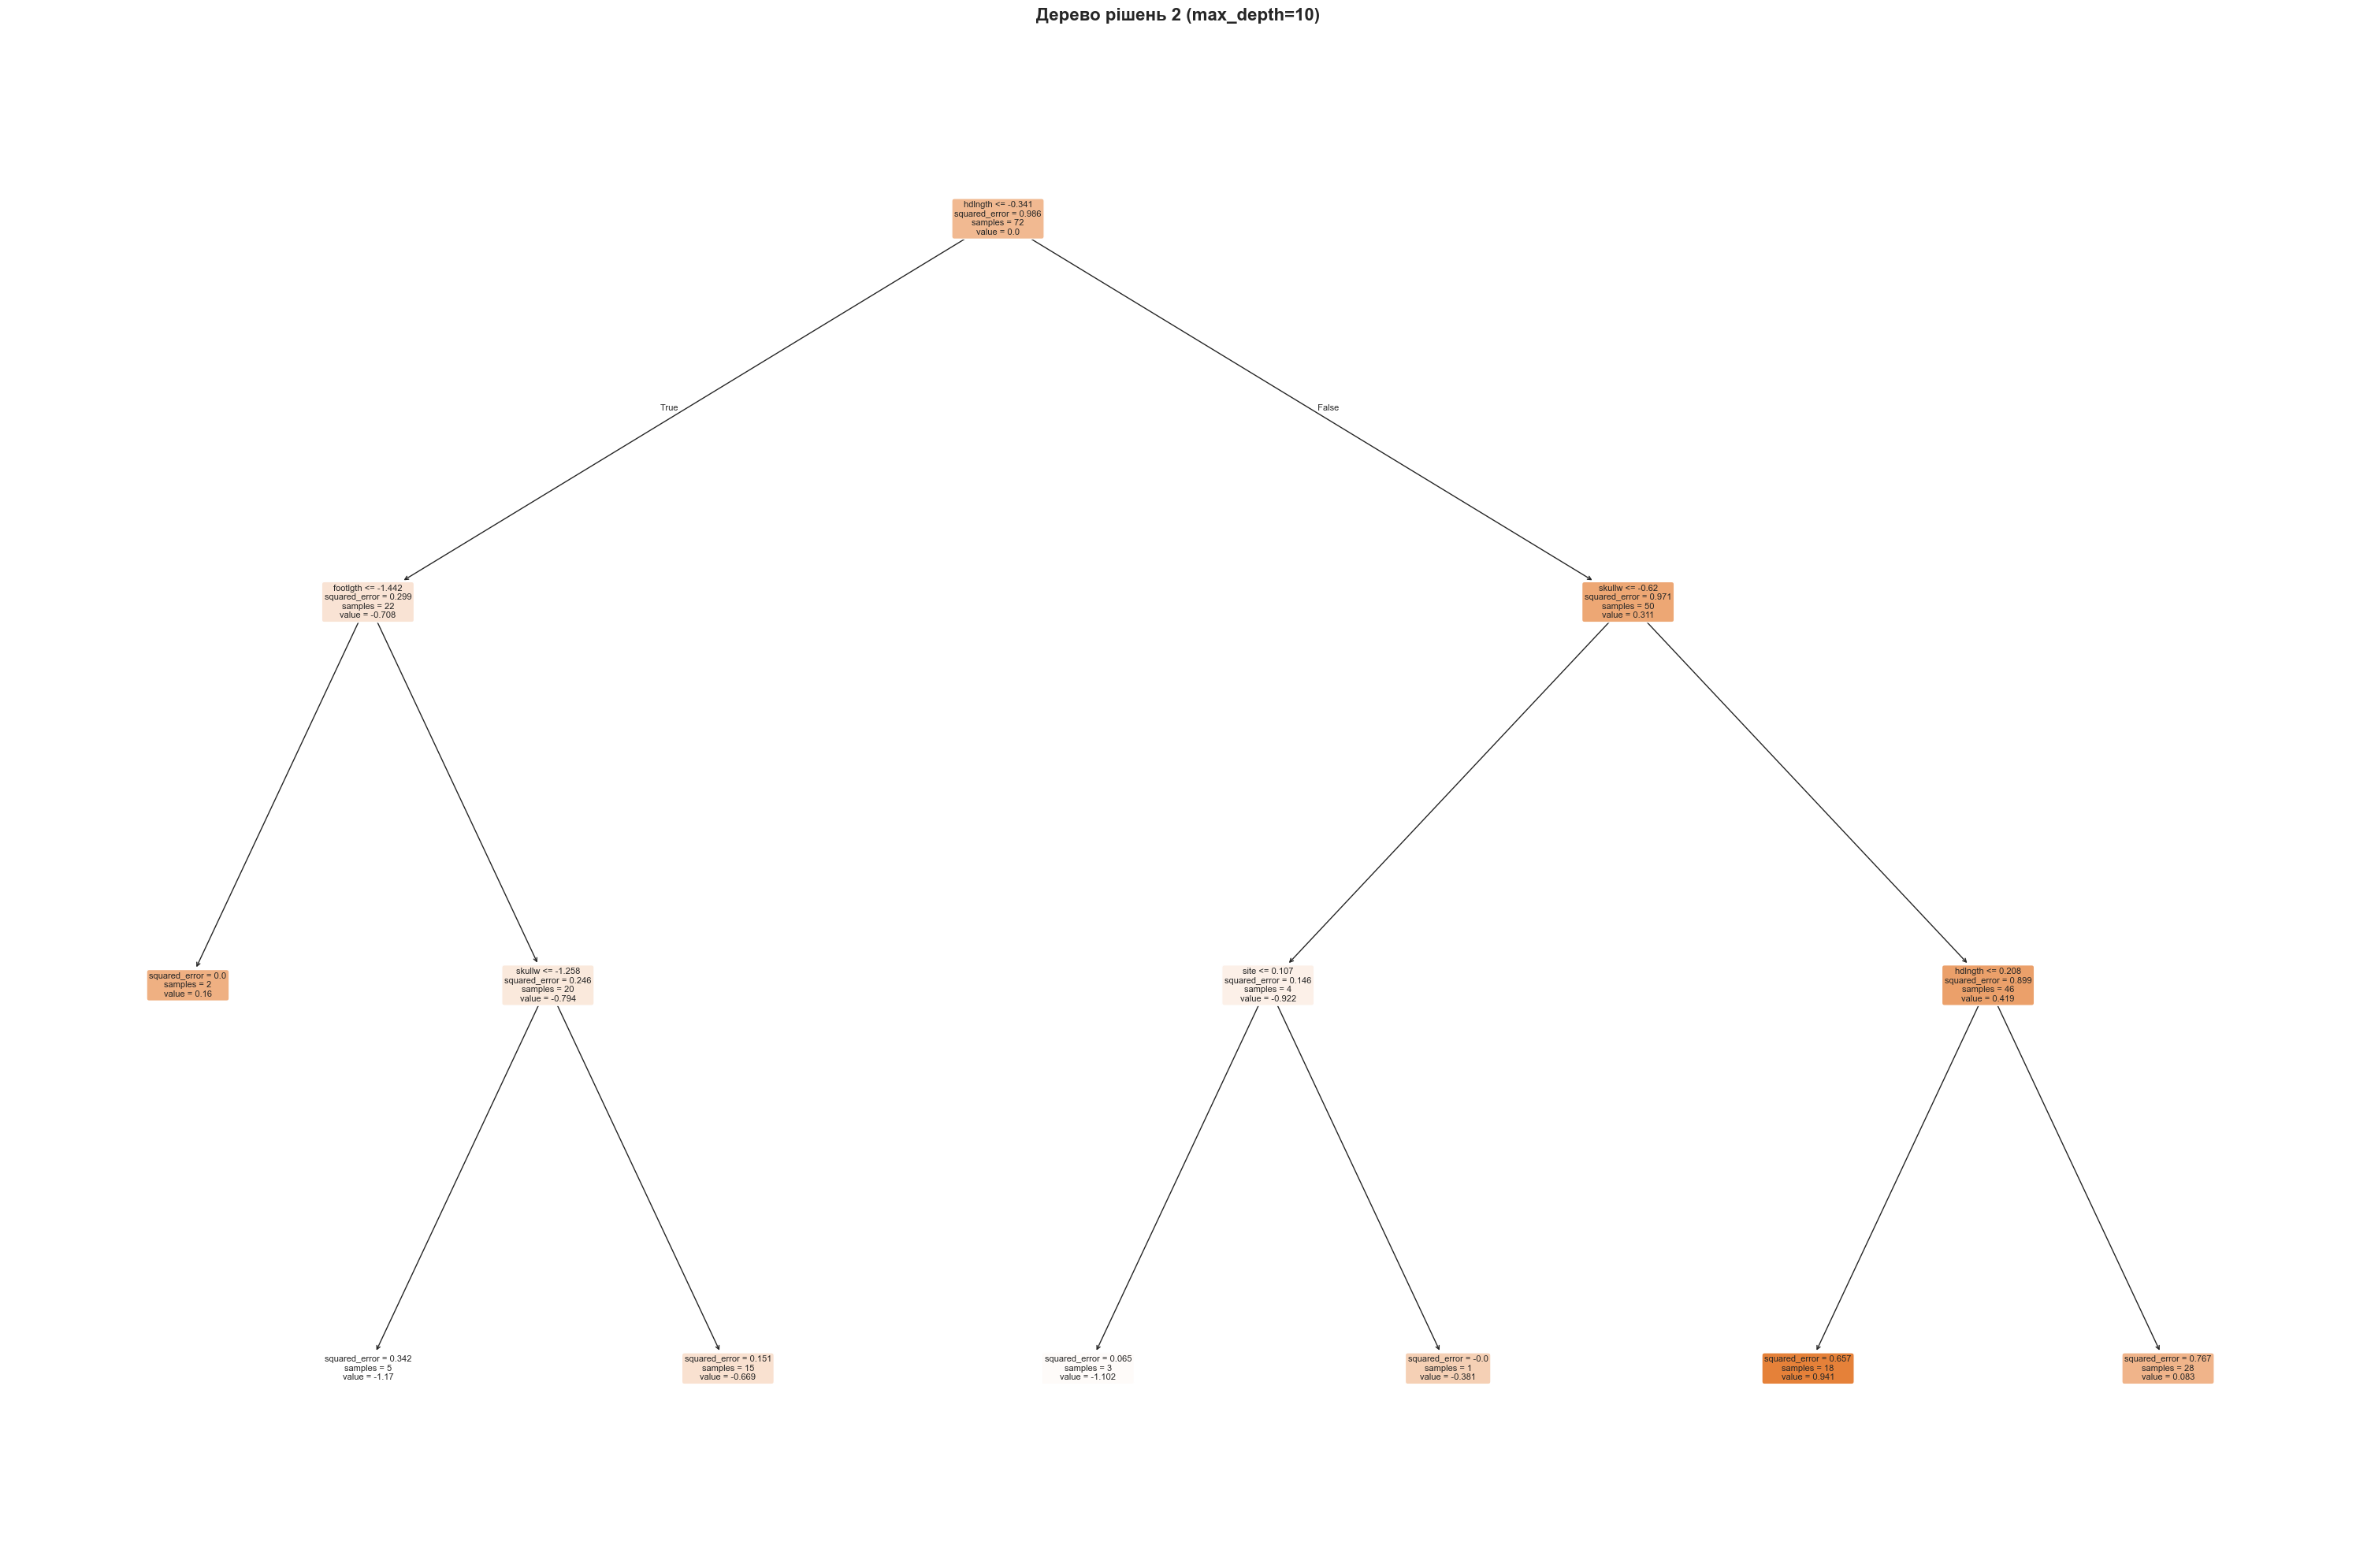

In [28]:
# Візуалізація другого дерева (depth=10)
plt.figure(figsize=(30, 20))
plot_tree(results['Дерево 2 (depth=3)']['model'],
          feature_names=X_train.columns,
          class_names=sorted(y_train.unique()),
          filled=True,
          rounded=True,
          fontsize=8)
plt.title('Дерево рішень 2 (max_depth=10)', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

Фактична глибина: 4
Кількість листків: 12


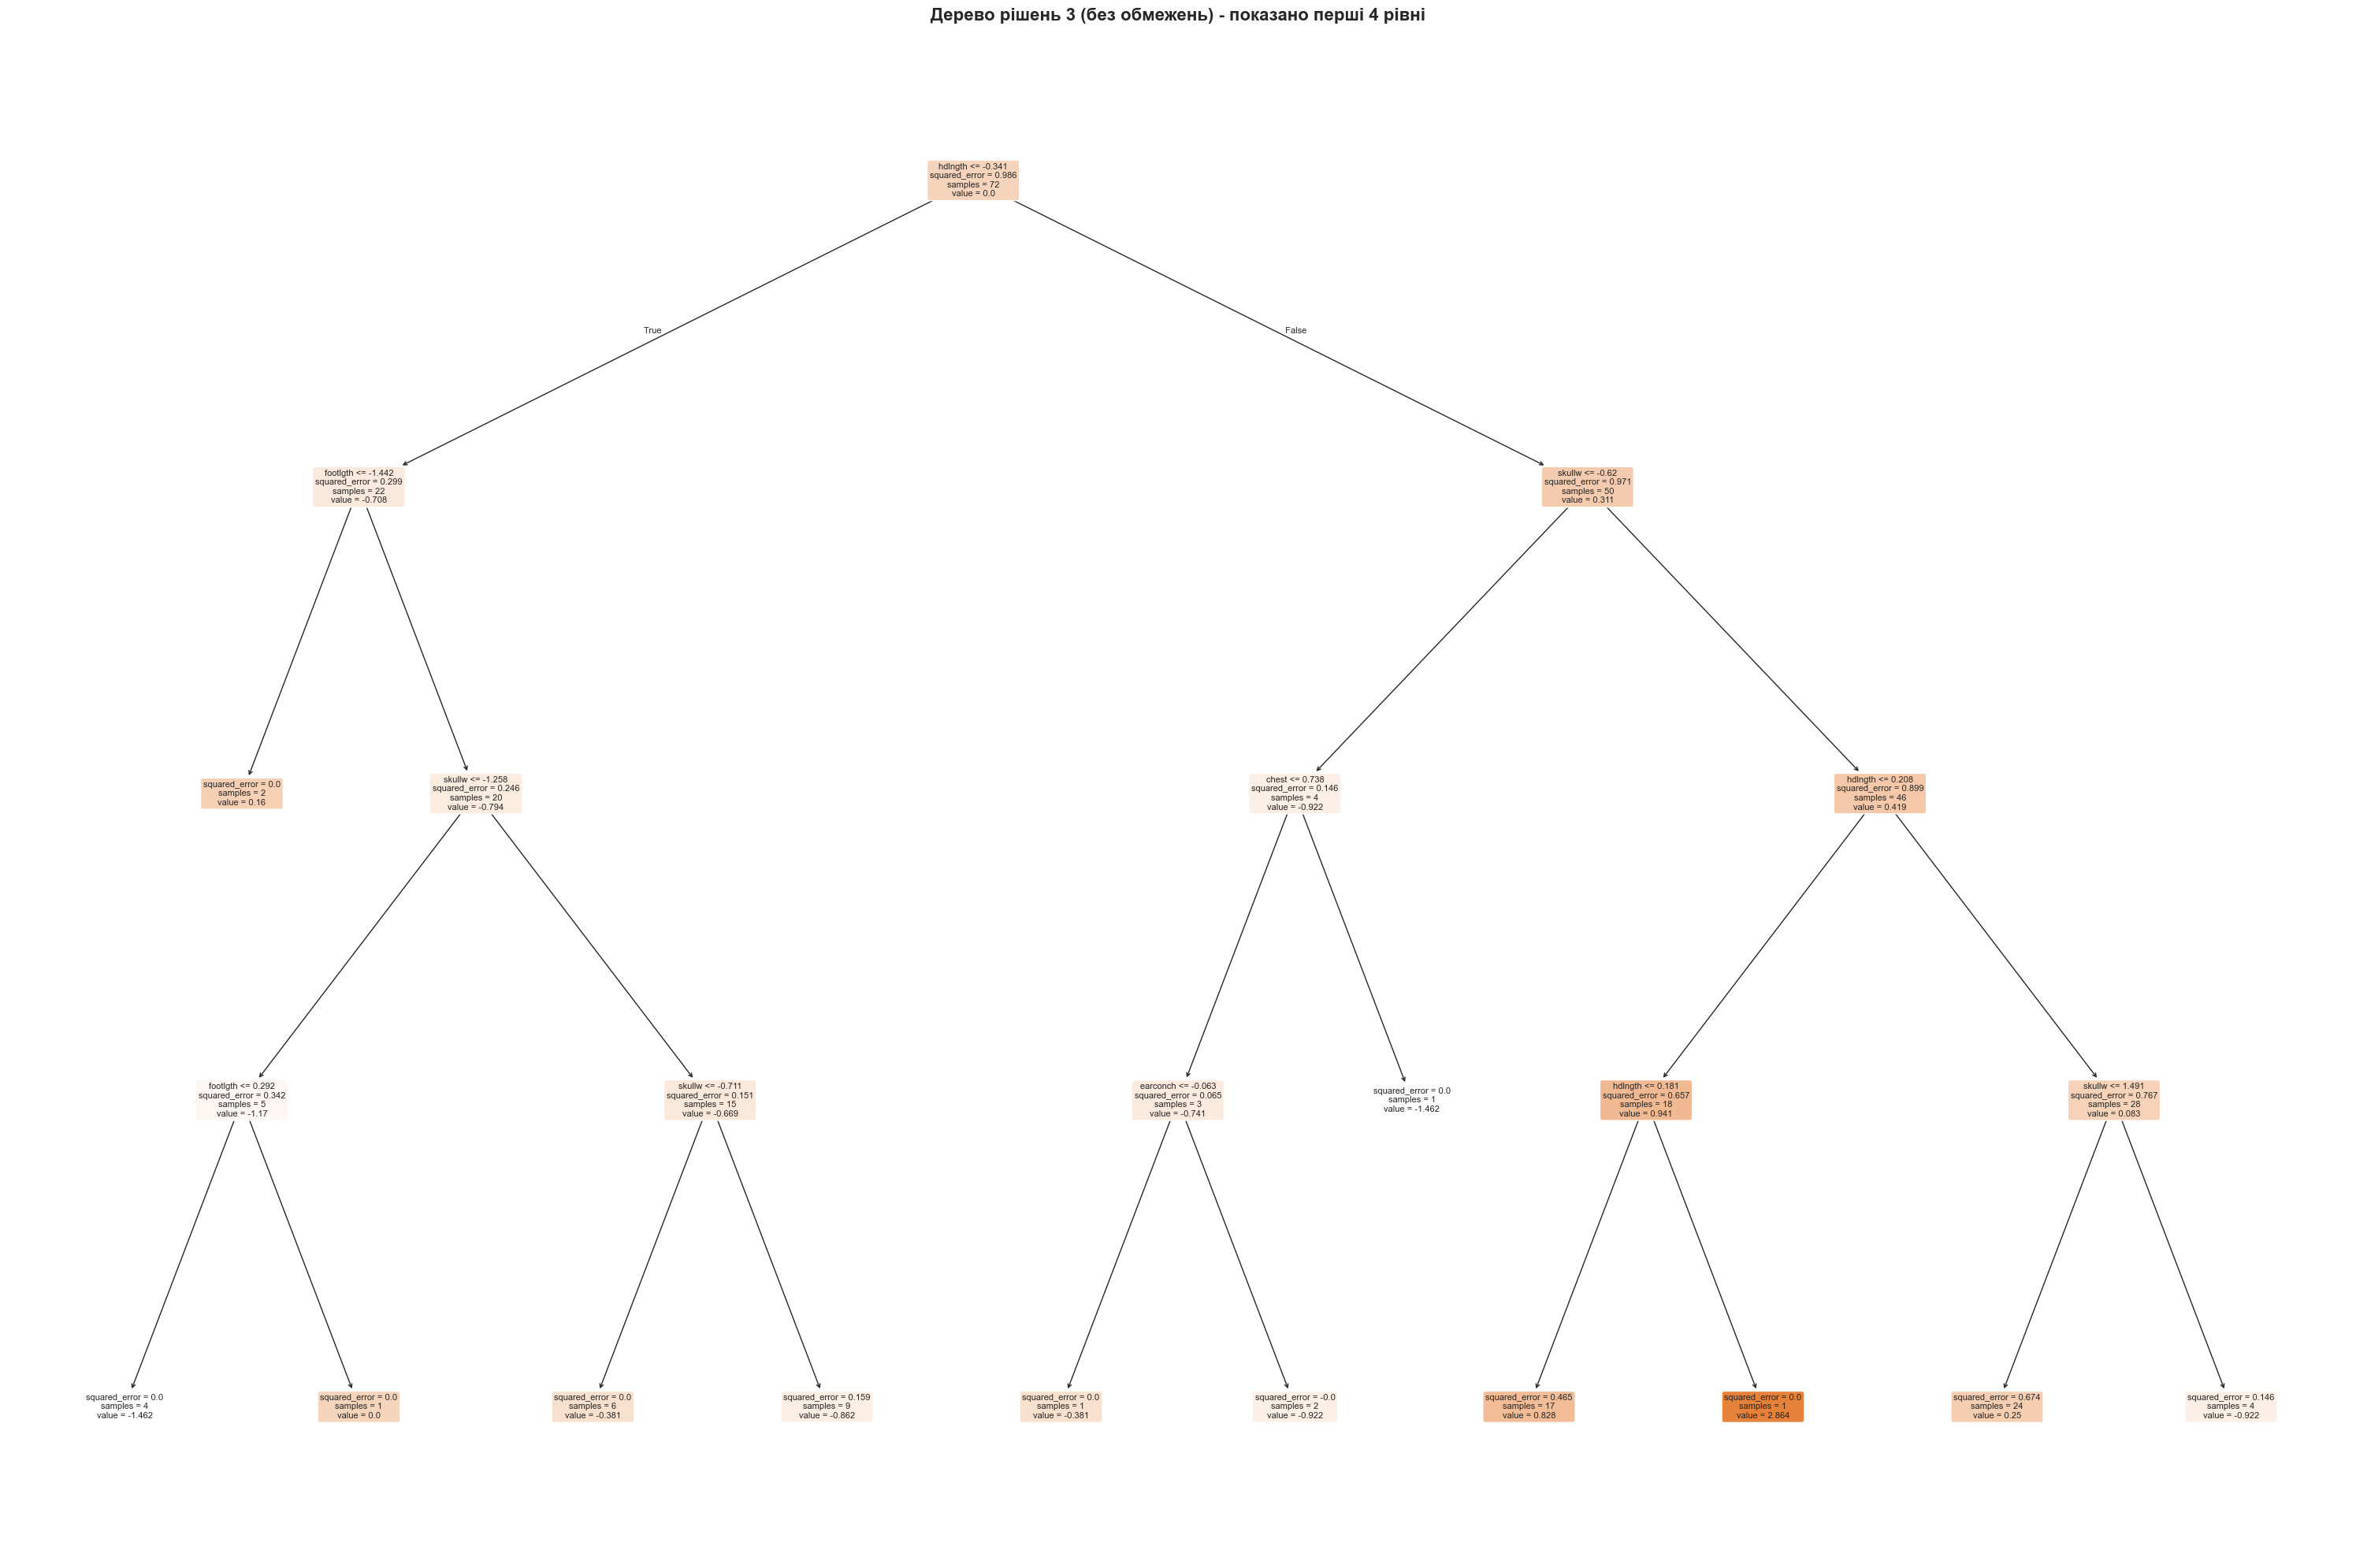

In [30]:
# Дерево без обмежень може бути дуже великим, тому візуалізуємо тільки частину
print(f"Фактична глибина: {results['Дерево 3 (depth=4)']['depth']}")
print(f"Кількість листків: {results['Дерево 3 (depth=4)']['n_leaves']}")

plt.figure(figsize=(30, 20))
plot_tree(results['Дерево 3 (depth=4)']['model'],
          feature_names=X_train.columns,
          class_names=sorted(y_train.unique()),
          filled=True,
          rounded=True,
          fontsize=8)  # Обмежуємо візуалізацію
plt.title('Дерево рішень 3 (без обмежень) - показано перші 4 рівні', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

## Частина 3. Зашумлення даних

Додамо до тренувальних даних випадковий шум з рівномірним розподілом uniform[-0.1, 0.1] для кожної ознаки.
Побудуємо 3 дерева рішень на зашумлених даних і порівняємо з оригінальними результатами.

In [32]:
# Додамо шум до тренувальних даних
# Використовуємо uniform розподіл в межах [-0.1, 0.1]
# ВАЖЛИВО: Шум додаємо ТІЛЬКИ до числових ознак, НЕ до one-hot encoded!

np.random.seed(42)  # Для відтворюваності результатів

# Створюємо копію тренувальних даних
X_train_noisy = X_train.copy()

# Визначаємо числові ознаки (виключаємо one-hot encoded колонки)
numeric_cols = [col for col in X_train.columns 
                if not col.startswith('Season_') and not col.startswith('Loc_')]
categorical_cols = [col for col in X_train.columns 
                    if col.startswith('Season_') or col.startswith('Loc_')]

print("=== ДОДАВАННЯ ШУМУ ДО ТРЕНУВАЛЬНИХ ДАНИХ ===\n")
print(f"Числові ознаки (до них додаємо шум): {len(numeric_cols)}")
print(f"  {numeric_cols}")
print(f"\nКатегоріальні ознаки (залишаємо без змін): {len(categorical_cols)}")
print(f"  {categorical_cols}")

# Додаємо шум ТІЛЬКИ до числових ознак
noise = np.random.uniform(-0.1, 0.1, size=(X_train_noisy.shape[0], len(numeric_cols)))
X_train_noisy[numeric_cols] = X_train_noisy[numeric_cols] + noise

print(f"\nДіапазон шуму: uniform[-0.1, 0.1]")
print(f"Форма оригінальних даних: {X_train.shape}")
print(f"Форма зашумлених даних: {X_train_noisy.shape}")

# Порівняємо оригінальні та зашумлені дані
print("\n=== ПРИКЛАД ЗАШУМЛЕННЯ (перші 3 рядки, перші 5 числових ознак) ===\n")
print("ОРИГІНАЛЬНІ ДАНІ:")
print(X_train[numeric_cols].iloc[:3, :5])
print("\nЗАШУМЛЕНІ ДАНІ:")
print(X_train_noisy[numeric_cols].iloc[:3, :5])
print("\nДОДАНИЙ ШУМ:")
print((X_train_noisy[numeric_cols] - X_train[numeric_cols]).iloc[:3, :5])

# Перевіримо що one-hot колонки залишились без змін
print("\n=== ПЕРЕВІРКА: One-hot колонки не змінились ===")
print(f"Чи рівні one-hot колонки? {X_train[categorical_cols].equals(X_train_noisy[categorical_cols])}")

=== ДОДАВАННЯ ШУМУ ДО ТРЕНУВАЛЬНИХ ДАНИХ ===

Числові ознаки (до них додаємо шум): 10
  ['site', 'hdlngth', 'skullw', 'totlngth', 'taill', 'footlgth', 'earconch', 'eye', 'chest', 'belly']

Категоріальні ознаки (залишаємо без змін): 0
  []

Діапазон шуму: uniform[-0.1, 0.1]
Форма оригінальних даних: (72, 10)
Форма зашумлених даних: (72, 10)

=== ПРИКЛАД ЗАШУМЛЕННЯ (перші 3 рядки, перші 5 числових ознак) ===

ОРИГІНАЛЬНІ ДАНІ:
         site   hdlngth    skullw  totlngth     taill
103  1.394763  0.249530  0.883289  0.379573  1.445747
78   0.965605 -1.893221 -2.123436 -1.376525 -0.371351
28  -1.180184  0.029760 -0.301179  0.160061 -1.150108

ЗАШУМЛЕНІ ДАНІ:
         site   hdlngth    skullw  totlngth     taill
103  1.369671  0.339673  0.929688  0.399305  1.376951
78   0.869722 -1.799239 -2.056948 -1.434057 -0.434986
28  -1.157813 -0.042341 -0.342750  0.133333 -1.158894

ДОДАНИЙ ШУМ:
         site   hdlngth    skullw  totlngth     taill
103 -0.025092  0.090143  0.046399  0.019732 -0.068796


In [102]:
# Навчимо дерева на зашумлених даних
trees_noisy = {
    'Дерево 1 (depth=3, noisy)': DecisionTreeClassifier(max_depth=3, random_state=42),
    'Дерево 2 (depth=10, noisy)': DecisionTreeClassifier(max_depth=10, random_state=42),
    'Дерево 3 (без обмежень, noisy)': DecisionTreeClassifier(random_state=42)
}

# Навчимо моделі на зашумлених даних
results_noisy = {}

print("=" * 80)
print("НАВЧАННЯ ДЕРЕВ РІШЕНЬ НА ЗАШУМЛЕНИХ ДАНИХ")
print("=" * 80)

for name, model in trees_noisy.items():
    print(f"\n{name}")
    print("-" * 80)
    
    # Вимірюємо час навчання
    start_time = time.time()
    model.fit(X_train_noisy, y_train)
    training_time = time.time() - start_time
    
    # Передбачення на зашумлених тренувальних та валідаційних вибірках
    y_train_pred = model.predict(X_train_noisy)
    y_val_pred = model.predict(X_val)  # Валідація БЕЗ шуму!
    
    # Обчислюємо точність
    train_accuracy = accuracy_score(y_train, y_train_pred)
    val_accuracy = accuracy_score(y_val, y_val_pred)
    
    # Зберігаємо результати
    results_noisy[name] = {
        'model': model,
        'train_accuracy': train_accuracy,
        'val_accuracy': val_accuracy,
        'training_time': training_time,
        'depth': model.get_depth(),
        'n_leaves': model.get_n_leaves()
    }
    
    print(f"  Час навчання: {training_time:.4f} сек")
    print(f"  Фактична глибина дерева: {model.get_depth()}")
    print(f"  Кількість листків: {model.get_n_leaves()}")
    print(f"  Точність на тренувальній вибірці (зашумленій): {train_accuracy:.4f} ({train_accuracy*100:.2f}%)")
    print(f"  Точність на валідаційній вибірці: {val_accuracy:.4f} ({val_accuracy*100:.2f}%)")
    print(f"  Різниця (overfitting): {(train_accuracy - val_accuracy)*100:.2f}%")

print("\n" + "=" * 80)

НАВЧАННЯ ДЕРЕВ РІШЕНЬ НА ЗАШУМЛЕНИХ ДАНИХ

Дерево 1 (depth=3, noisy)
--------------------------------------------------------------------------------
  Час навчання: 0.0316 сек
  Фактична глибина дерева: 3
  Кількість листків: 8
  Точність на тренувальній вибірці (зашумленій): 0.7693 (76.93%)
  Точність на валідаційній вибірці: 0.8278 (82.78%)
  Різниця (overfitting): -5.85%

Дерево 2 (depth=10, noisy)
--------------------------------------------------------------------------------
  Час навчання: 0.0654 сек
  Фактична глибина дерева: 10
  Кількість листків: 286
  Точність на тренувальній вибірці (зашумленій): 0.9389 (93.89%)
  Точність на валідаційній вибірці: 0.9056 (90.56%)
  Різниця (overfitting): 3.33%

Дерево 3 (без обмежень, noisy)
--------------------------------------------------------------------------------
  Час навчання: 0.0941 сек
  Фактична глибина дерева: 27
  Кількість листків: 754
  Точність на тренувальній вибірці (зашумленій): 1.0000 (100.00%)
  Точність на валідаці

In [103]:
# Порівняльна таблиця: оригінальні vs зашумлені дані
print("=" * 100)
print("ПОРІВНЯННЯ РЕЗУЛЬТАТІВ: ОРИГІНАЛЬНІ vs ЗАШУМЛЕНІ ДАНІ")
print("=" * 100)

comparison_data_full = []

# Додаємо результати оригінальних дерев
for name, res in results.items():
    depth_str = name.split('depth=')[1].split(')')[0] if 'depth=' in name else 'None'
    comparison_data_full.append({
        'Тип даних': 'Оригінальні',
        'Max Depth': depth_str,
        'Фактична глибина': res['depth'],
        'Листків': res['n_leaves'],
        'Train Acc': f"{res['train_accuracy']:.4f}",
        'Val Acc': f"{res['val_accuracy']:.4f}",
        'Overfitting': f"{(res['train_accuracy'] - res['val_accuracy'])*100:.2f}%"
    })

# Додаємо результати зашумлених дерев
for name, res in results_noisy.items():
    depth_str = name.split('depth=')[1].split(',')[0] if 'depth=' in name else 'None'
    comparison_data_full.append({
        'Тип даних': 'Зашумлені',
        'Max Depth': depth_str,
        'Фактична глибина': res['depth'],
        'Листків': res['n_leaves'],
        'Train Acc': f"{res['train_accuracy']:.4f}",
        'Val Acc': f"{res['val_accuracy']:.4f}",
        'Overfitting': f"{(res['train_accuracy'] - res['val_accuracy'])*100:.2f}%"
    })

comparison_full_df = pd.DataFrame(comparison_data_full)
print("\n")
print(comparison_full_df.to_string(index=False))

ПОРІВНЯННЯ РЕЗУЛЬТАТІВ: ОРИГІНАЛЬНІ vs ЗАШУМЛЕНІ ДАНІ


  Тип даних Max Depth  Фактична глибина  Листків Train Acc Val Acc Overfitting
Оригінальні         3                 3        8    0.8776  0.8737       0.39%
Оригінальні        10                10      220    0.9588  0.9096       4.92%
Оригінальні      None                20      521    1.0000  0.9101       8.99%
  Зашумлені         3                 3        8    0.7693  0.8278      -5.85%
  Зашумлені        10                10      286    0.9389  0.9056       3.33%
  Зашумлені      None                27      754    1.0000  0.9030       9.70%


## Частина 4. PCA аналіз та знешумлення

Обрахуємо PCA на оригінальних та зашумлених даних, візуалізуємо компоненти, та використаємо PCA для знешумлення даних.

In [104]:
from sklearn.decomposition import PCA

# 1. PCA на оригінальних даних
pca_original = PCA()
pca_original.fit(X_train)

# 2. PCA на зашумлених даних
pca_noisy = PCA()
pca_noisy.fit(X_train_noisy)

print("=" * 80)
print("PCA АНАЛІЗ")
print("=" * 80)

print("\n=== ОРИГІНАЛЬНІ ДАНІ ===")
print(f"Кількість компонент: {pca_original.n_components_}")
print(f"Пояснена variance (перші 5 компонент): {pca_original.explained_variance_ratio_[:5]}")
print(f"Сумарна variance (всі компоненти): {pca_original.explained_variance_ratio_.sum():.4f}")

print("\n=== ЗАШУМЛЕНІ ДАНІ ===")
print(f"Кількість компонент: {pca_noisy.n_components_}")
print(f"Пояснена variance (перші 5 компонент): {pca_noisy.explained_variance_ratio_[:5]}")
print(f"Сумарна variance (всі компоненти): {pca_noisy.explained_variance_ratio_.sum():.4f}")

# Знайдемо кількість компонент для 99% variance
cumsum_original = np.cumsum(pca_original.explained_variance_ratio_)
cumsum_noisy = np.cumsum(pca_noisy.explained_variance_ratio_)

n_components_99_original = np.argmax(cumsum_original >= 0.99) + 1
n_components_99_noisy = np.argmax(cumsum_noisy >= 0.99) + 1

print("\n=== КОМПОНЕНТИ ДЛЯ 99% VARIANCE ===")
print(f"Оригінальні дані: {n_components_99_original} компонент")
print(f"Зашумлені дані: {n_components_99_noisy} компонент")

PCA АНАЛІЗ

=== ОРИГІНАЛЬНІ ДАНІ ===
Кількість компонент: 15
Пояснена variance (перші 5 компонент): [0.35133343 0.13257518 0.09743933 0.07516244 0.06476401]
Сумарна variance (всі компоненти): 1.0000

=== ЗАШУМЛЕНІ ДАНІ ===
Кількість компонент: 15
Пояснена variance (перші 5 компонент): [0.3358147  0.13167785 0.0987362  0.07824949 0.06839702]
Сумарна variance (всі компоненти): 1.0000

=== КОМПОНЕНТИ ДЛЯ 99% VARIANCE ===
Оригінальні дані: 13 компонент
Зашумлені дані: 13 компонент


🔵 ОРИГІНАЛЬНІ ДАНІ


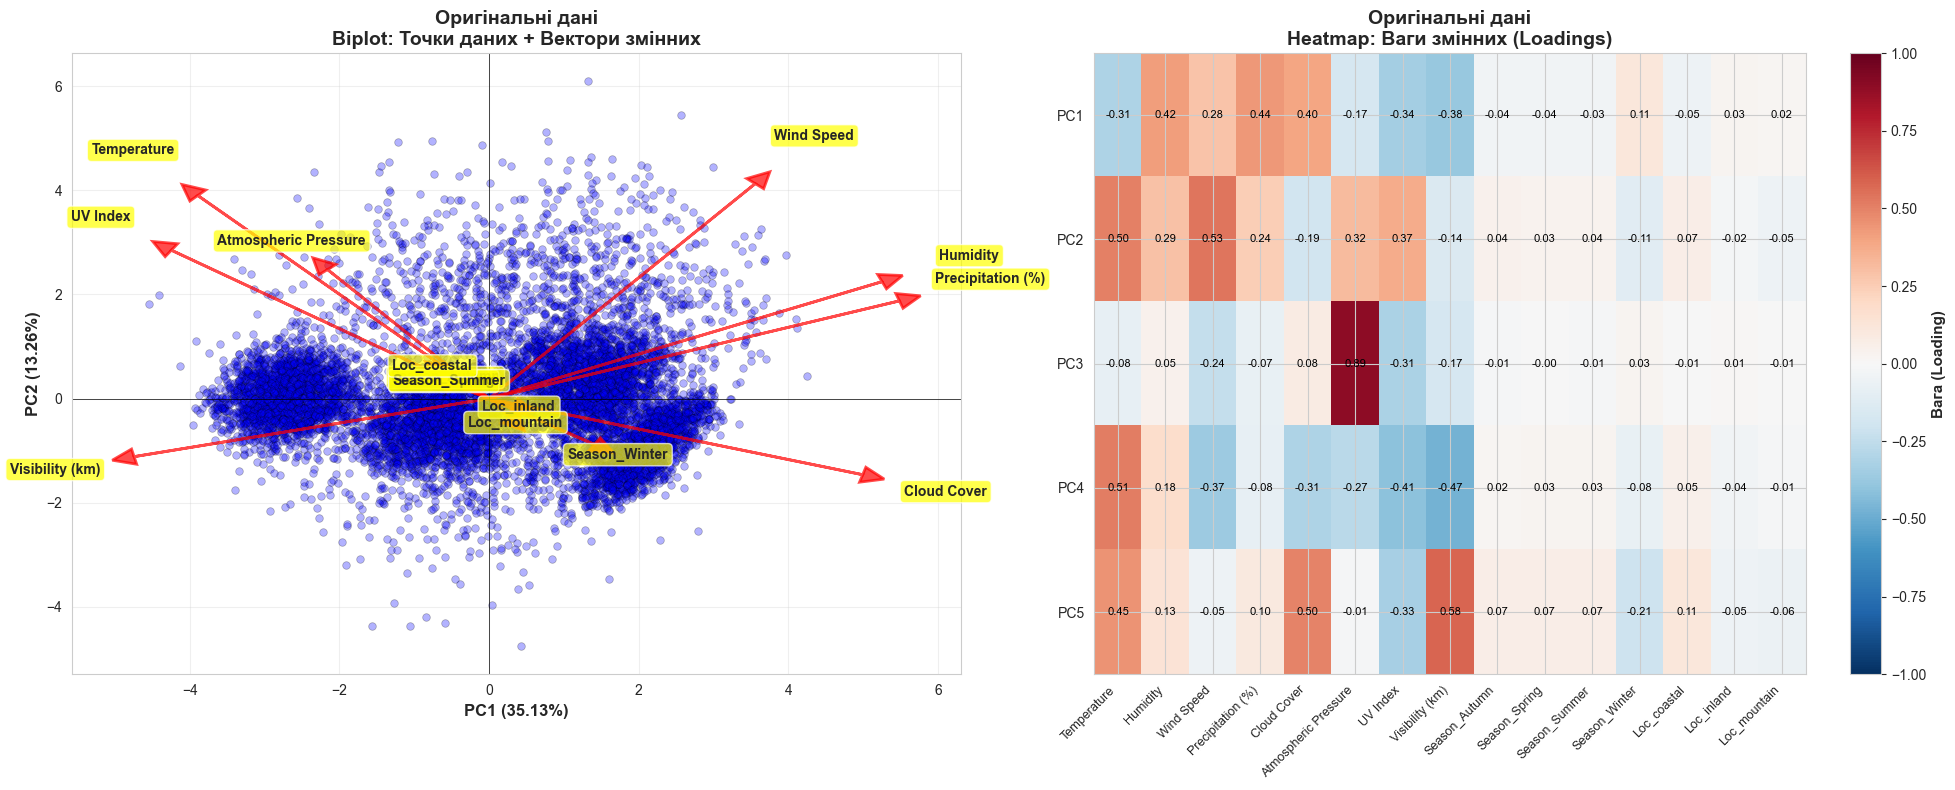


ІНФОРМАЦІЯ ПРО PCA: Оригінальні дані

Пояснена варіація (перші 5 компонент):
  PC1: 35.13% (кумулятивна: 35.13%)
  PC2: 13.26% (кумулятивна: 48.39%)
  PC3: 9.74% (кумулятивна: 58.13%)
  PC4: 7.52% (кумулятивна: 65.65%)
  PC5: 6.48% (кумулятивна: 72.13%)

Найвпливовіші змінні для PC1:
  Precipitation (%): 0.435
  Humidity: 0.417
  Cloud Cover: 0.396
  Visibility (km): -0.376
  UV Index: -0.337

Найвпливовіші змінні для PC2:
  Wind Speed: 0.533
  Temperature: 0.504
  UV Index: 0.368
  Atmospheric Pressure: 0.320
  Humidity: 0.290

🔴 ЗАШУМЛЕНІ ДАНІ


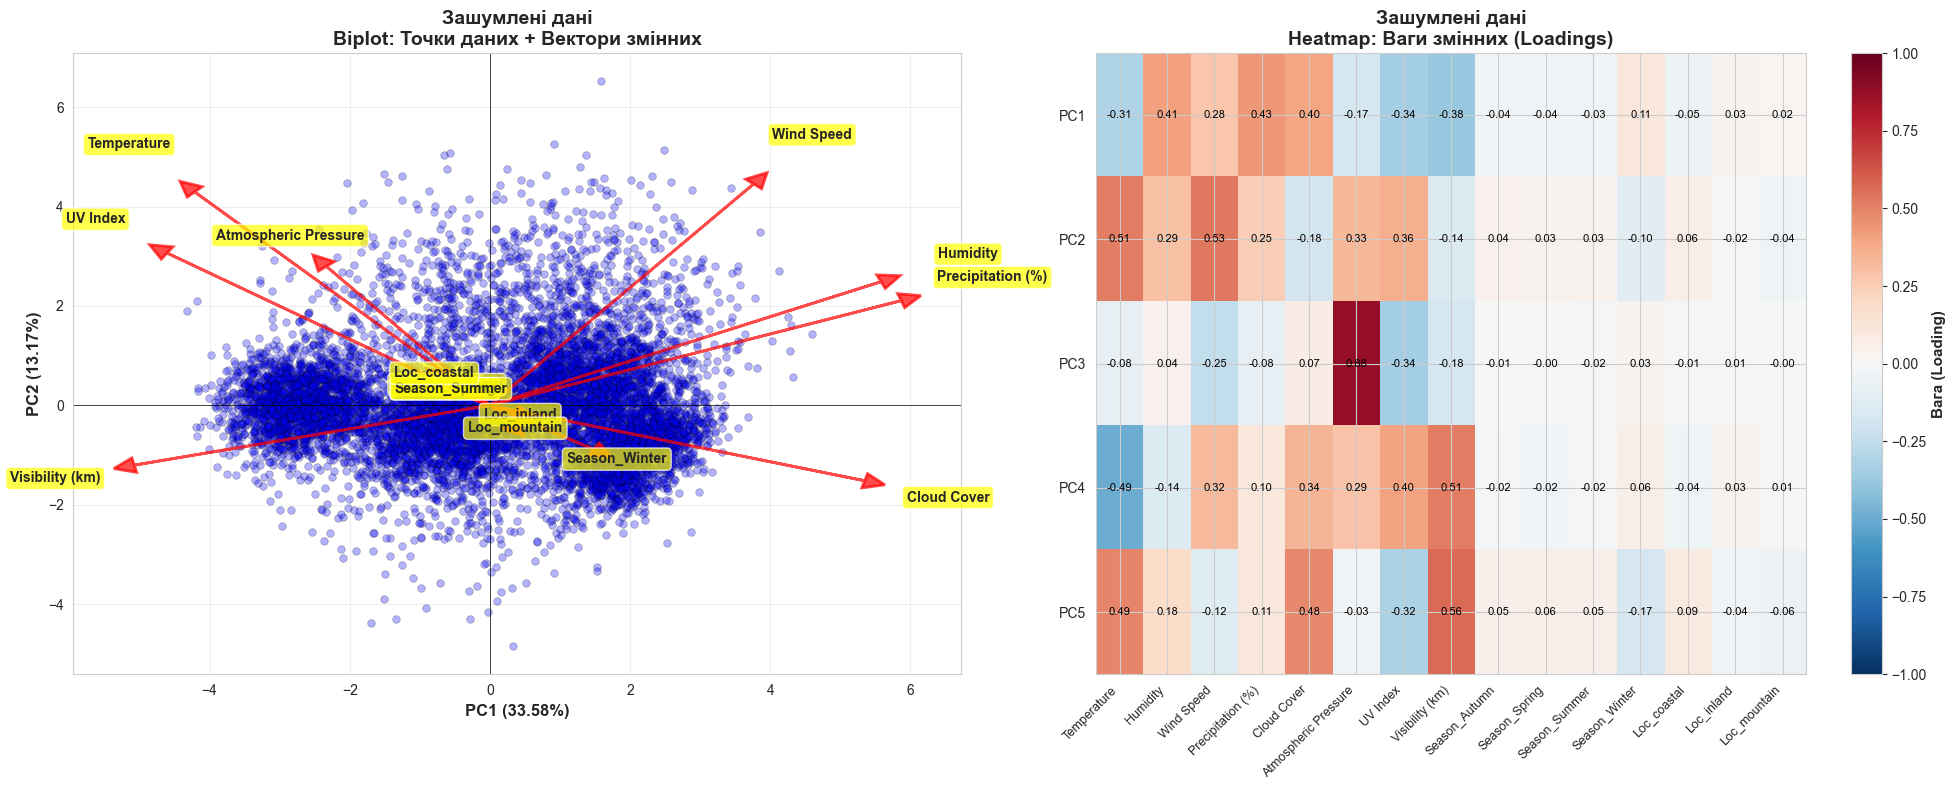


ІНФОРМАЦІЯ ПРО PCA: Зашумлені дані

Пояснена варіація (перші 5 компонент):
  PC1: 33.58% (кумулятивна: 33.58%)
  PC2: 13.17% (кумулятивна: 46.75%)
  PC3: 9.87% (кумулятивна: 56.62%)
  PC4: 7.82% (кумулятивна: 64.45%)
  PC5: 6.84% (кумулятивна: 71.29%)

Найвпливовіші змінні для PC1:
  Precipitation (%): 0.435
  Humidity: 0.414
  Cloud Cover: 0.396
  Visibility (km): -0.376
  UV Index: -0.341

Найвпливовіші змінні для PC2:
  Wind Speed: 0.527
  Temperature: 0.508
  UV Index: 0.363
  Atmospheric Pressure: 0.331
  Humidity: 0.294


In [116]:
# Візуалізація векторів змінних PCA (Biplot)
import matplotlib.pyplot as plt
import numpy as np

def plot_pca_vectors(pca_model, feature_names, X_transformed, title, n_components=2):
    """
    Візуалізація векторів змінних PCA (loadings) та точок даних
    """
    fig, axes = plt.subplots(1, 2, figsize=(20, 8))
    
    # --- Графік 1: Biplot (точки даних + вектори змінних) ---
    ax1 = axes[0]
    
    # Візуалізація точок даних (перші 2 компоненти)
    scatter = ax1.scatter(X_transformed[:, 0], X_transformed[:, 1], 
                         alpha=0.3, s=30, c='blue', edgecolors='k', linewidth=0.5)
    
    # Візуалізація векторів змінних (loadings)
    loadings = pca_model.components_.T * np.sqrt(pca_model.explained_variance_)
    
    # Масштабуємо вектори для кращої видимості
    scale_factor = max(abs(X_transformed[:, 0].max()), abs(X_transformed[:, 1].max())) / \
                   max(abs(loadings[:, 0].max()), abs(loadings[:, 1].max()))
    
    for i, feature in enumerate(feature_names):
        ax1.arrow(0, 0, 
                 loadings[i, 0] * scale_factor * 0.9, 
                 loadings[i, 1] * scale_factor * 0.9,
                 head_width=0.3, head_length=0.3, fc='red', ec='red', 
                 linewidth=2, alpha=0.7)
        
        # Додаємо назви змінних
        ax1.text(loadings[i, 0] * scale_factor * 1.1, 
                loadings[i, 1] * scale_factor * 1.1,
                feature, fontsize=10, fontweight='bold', 
                ha='center', va='center',
                bbox=dict(boxstyle='round,pad=0.3', facecolor='yellow', alpha=0.7))
    
    ax1.set_xlabel(f'PC1 ({pca_model.explained_variance_ratio_[0]*100:.2f}%)', 
                   fontsize=12, fontweight='bold')
    ax1.set_ylabel(f'PC2 ({pca_model.explained_variance_ratio_[1]*100:.2f}%)', 
                   fontsize=12, fontweight='bold')
    ax1.set_title(f'{title}\nBiplot: Точки даних + Вектори змінних', 
                  fontsize=14, fontweight='bold')
    ax1.grid(True, alpha=0.3)
    ax1.axhline(y=0, color='k', linewidth=0.5)
    ax1.axvline(x=0, color='k', linewidth=0.5)
    
    # --- Графік 2: Heatmap векторів змінних (loadings) ---
    ax2 = axes[1]
    
    # Візуалізуємо loadings для перших компонент
    n_comp_to_show = min(5, pca_model.n_components_)
    loadings_matrix = pca_model.components_[:n_comp_to_show, :]
    
    im = ax2.imshow(loadings_matrix, cmap='RdBu_r', aspect='auto', vmin=-1, vmax=1)
    
    # Додаємо colorbar
    cbar = plt.colorbar(im, ax=ax2)
    cbar.set_label('Вага (Loading)', fontsize=11, fontweight='bold')
    
    # Налаштовуємо осі
    ax2.set_xticks(np.arange(len(feature_names)))
    ax2.set_yticks(np.arange(n_comp_to_show))
    ax2.set_xticklabels(feature_names, rotation=45, ha='right', fontsize=9)
    ax2.set_yticklabels([f'PC{i+1}' for i in range(n_comp_to_show)], fontsize=10)
    
    # Додаємо значення в клітинки
    for i in range(n_comp_to_show):
        for j in range(len(feature_names)):
            text = ax2.text(j, i, f'{loadings_matrix[i, j]:.2f}',
                          ha="center", va="center", color="black", fontsize=8)
    
    ax2.set_title(f'{title}\nHeatmap: Ваги змінних (Loadings)', 
                  fontsize=14, fontweight='bold')
    
    plt.tight_layout()
    plt.show()
    
    # --- Додаткова інформація ---
    print(f"\n{'='*80}")
    print(f"ІНФОРМАЦІЯ ПРО PCA: {title}")
    print(f"{'='*80}")
    print(f"\nПояснена варіація (перші 5 компонент):")
    for i in range(min(5, len(pca_model.explained_variance_ratio_))):
        print(f"  PC{i+1}: {pca_model.explained_variance_ratio_[i]*100:.2f}% "
              f"(кумулятивна: {np.sum(pca_model.explained_variance_ratio_[:i+1])*100:.2f}%)")
    
    print(f"\nНайвпливовіші змінні для PC1:")
    pc1_loadings = np.abs(pca_model.components_[0])
    top_features_pc1 = np.argsort(pc1_loadings)[-5:][::-1]
    for idx in top_features_pc1:
        print(f"  {feature_names[idx]}: {pca_model.components_[0][idx]:.3f}")
    
    print(f"\nНайвпливовіші змінні для PC2:")
    pc2_loadings = np.abs(pca_model.components_[1])
    top_features_pc2 = np.argsort(pc2_loadings)[-5:][::-1]
    for idx in top_features_pc2:
        print(f"  {feature_names[idx]}: {pca_model.components_[1][idx]:.3f}")

# Візуалізація для оригінальних даних
print("🔵 ОРИГІНАЛЬНІ ДАНІ")
X_train_pca_original = pca_original.transform(X_train)
plot_pca_vectors(pca_original, X_train.columns.tolist(), 
                X_train_pca_original, "Оригінальні дані")

# Візуалізація для зашумлених даних
print("\n" + "="*80)
print("🔴 ЗАШУМЛЕНІ ДАНІ")
print("="*80)
X_train_pca_noisy = pca_noisy.transform(X_train_noisy)
plot_pca_vectors(pca_noisy, X_train.columns.tolist(), 
                X_train_pca_noisy, "Зашумлені дані")

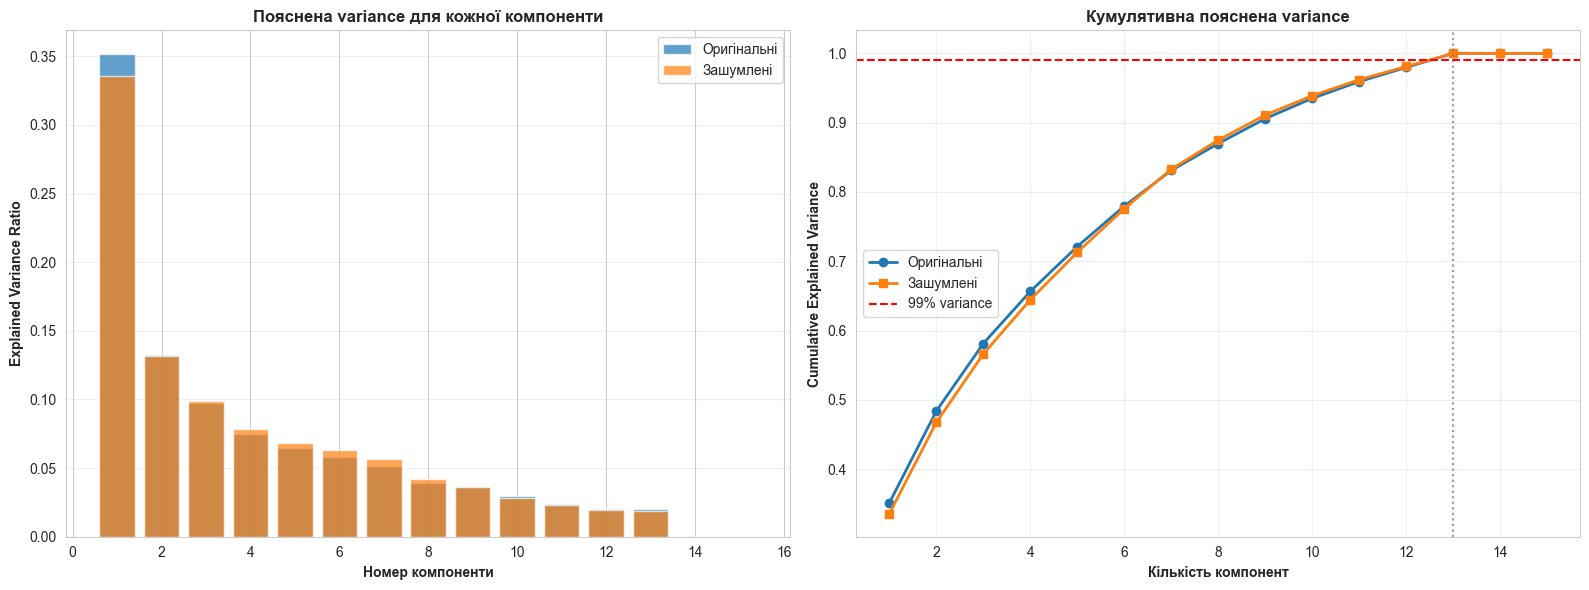


Для 99% variance потрібно:
  Оригінальні дані: 13 компонент
  Зашумлені дані: 13 компонент


In [105]:
# Візуалізація поясненої variance для обох PCA
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Графік 1: Explained variance ratio
axes[0].bar(range(1, len(pca_original.explained_variance_ratio_) + 1), 
            pca_original.explained_variance_ratio_, 
            alpha=0.7, label='Оригінальні')
axes[0].bar(range(1, len(pca_noisy.explained_variance_ratio_) + 1), 
            pca_noisy.explained_variance_ratio_, 
            alpha=0.7, label='Зашумлені')
axes[0].set_xlabel('Номер компоненти', fontweight='bold')
axes[0].set_ylabel('Explained Variance Ratio', fontweight='bold')
axes[0].set_title('Пояснена variance для кожної компоненти', fontweight='bold')
axes[0].legend()
axes[0].grid(axis='y', alpha=0.3)

# Графік 2: Cumulative explained variance
axes[1].plot(range(1, len(cumsum_original) + 1), cumsum_original, 
             'o-', label='Оригінальні', linewidth=2)
axes[1].plot(range(1, len(cumsum_noisy) + 1), cumsum_noisy, 
             's-', label='Зашумлені', linewidth=2)
axes[1].axhline(y=0.99, color='r', linestyle='--', label='99% variance')
axes[1].axvline(x=n_components_99_original, color='blue', linestyle=':', alpha=0.5)
axes[1].axvline(x=n_components_99_noisy, color='orange', linestyle=':', alpha=0.5)
axes[1].set_xlabel('Кількість компонент', fontweight='bold')
axes[1].set_ylabel('Cumulative Explained Variance', fontweight='bold')
axes[1].set_title('Кумулятивна пояснена variance', fontweight='bold')
axes[1].legend()
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\nДля 99% variance потрібно:")
print(f"  Оригінальні дані: {n_components_99_original} компонент")
print(f"  Зашумлені дані: {n_components_99_noisy} компонент")

In [106]:
# Реконструкція даних використовуючи PCA для знешумлення
# Використовуємо компоненти що пояснюють 99% variance

# Створюємо PCA з обмеженою кількістю компонент
pca_denoising = PCA(n_components=n_components_99_noisy)
pca_denoising.fit(X_train_noisy)

# Трансформуємо зашумлені дані в простір головних компонент
X_train_pca = pca_denoising.transform(X_train_noisy)

# Реконструюємо дані назад (знешумлення)
X_train_denoised = pca_denoising.inverse_transform(X_train_pca)

# Конвертуємо назад в DataFrame
X_train_denoised = pd.DataFrame(X_train_denoised, 
                                 columns=X_train.columns, 
                                 index=X_train.index)

print("=" * 80)
print("ЗНЕШУМЛЕННЯ ДАНИХ ЗА ДОПОМОГОЮ PCA")
print("=" * 80)
print(f"\nВикористано компонент: {n_components_99_noisy}")
print(f"Пояснено variance: {pca_denoising.explained_variance_ratio_.sum():.4f} ({pca_denoising.explained_variance_ratio_.sum()*100:.2f}%)")
print(f"\nФорма оригінальних даних: {X_train.shape}")
print(f"Форма зашумлених даних: {X_train_noisy.shape}")
print(f"Форма знешумлених даних: {X_train_denoised.shape}")

# Обчислимо помилку реконструкції
reconstruction_error = np.mean((X_train_noisy.values - X_train_denoised.values) ** 2)
print(f"\nПомилка реконструкції (MSE): {reconstruction_error:.6f}")

ЗНЕШУМЛЕННЯ ДАНИХ ЗА ДОПОМОГОЮ PCA

Використано компонент: 13
Пояснено variance: 1.0000 (100.00%)

Форма оригінальних даних: (9240, 15)
Форма зашумлених даних: (9240, 15)
Форма знешумлених даних: (9240, 15)

Помилка реконструкції (MSE): 0.000000


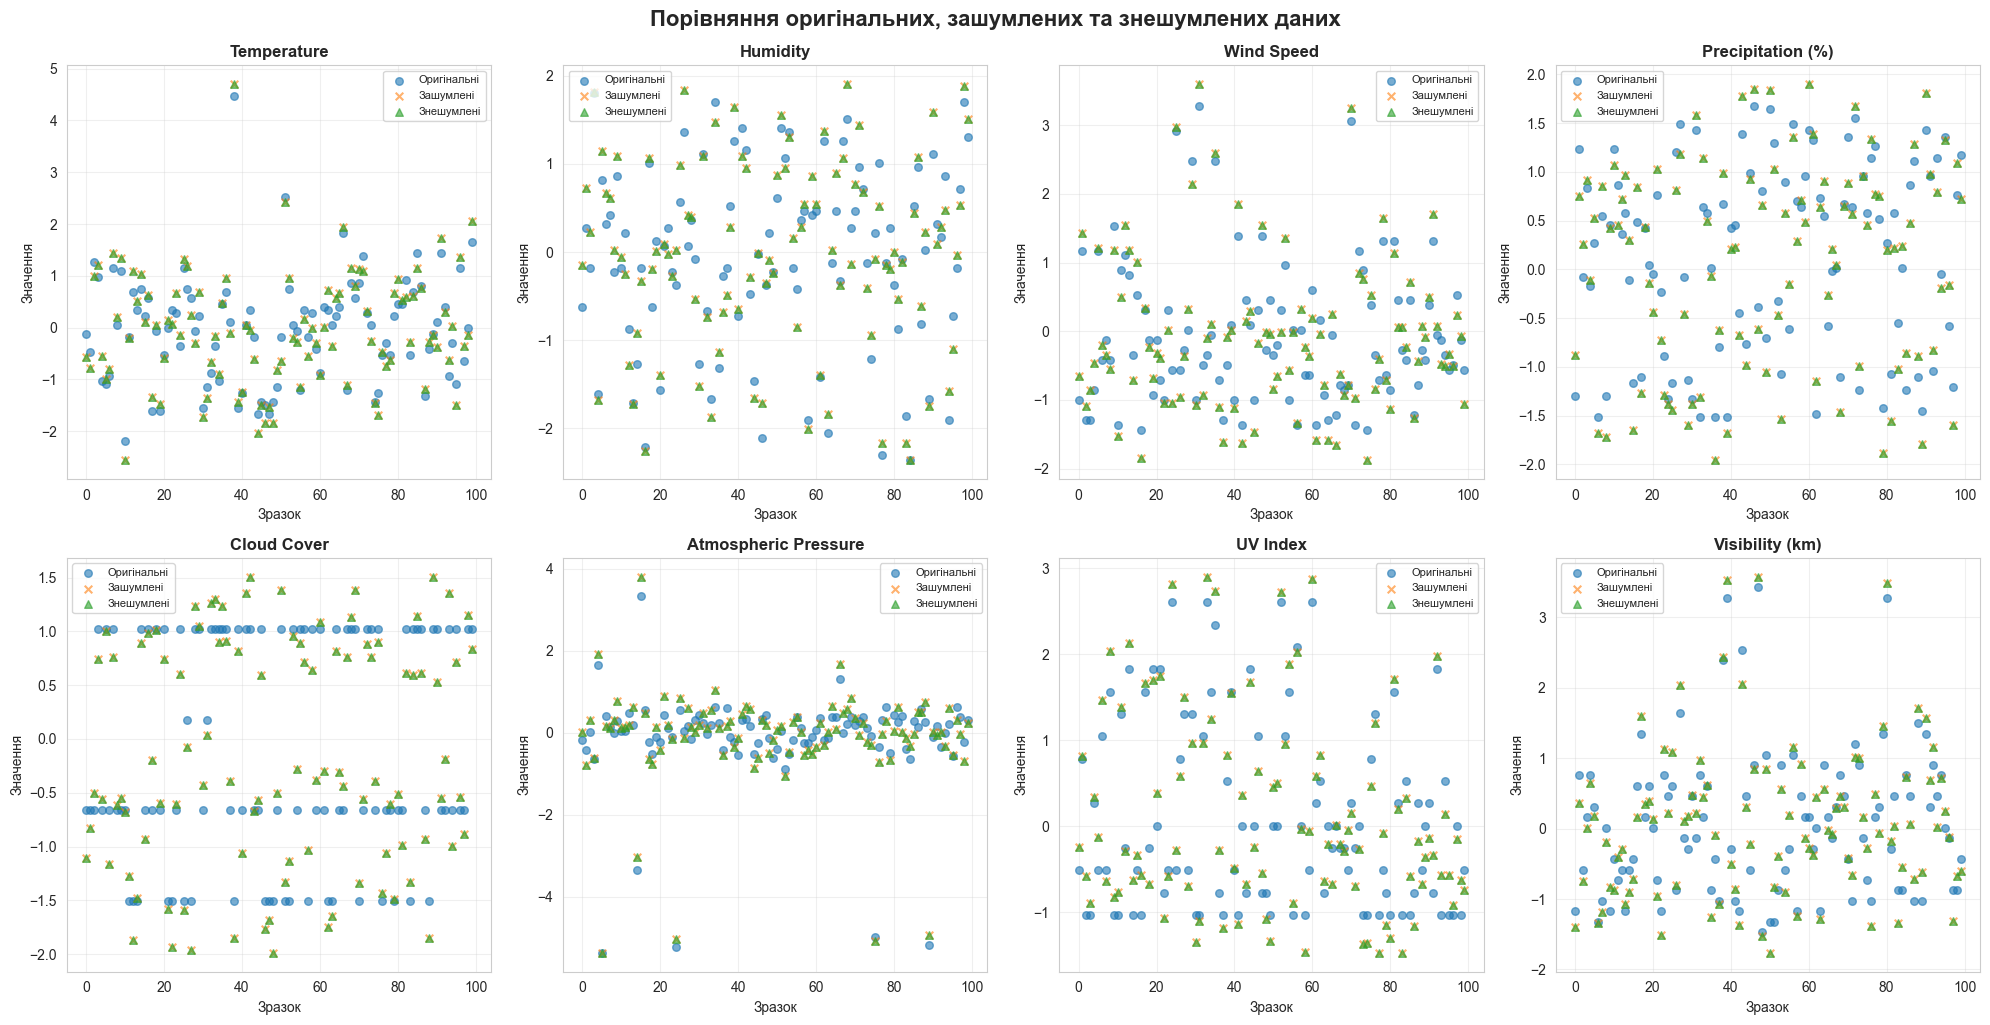

In [107]:
# Візуалізація порівняння оригінальних, зашумлених і знешумлених даних
# Візуалізуємо тільки числові ознаки

fig, axes = plt.subplots(2, 4, figsize=(20, 10))
axes = axes.flatten()

# Вибираємо 8 числових ознак для візуалізації
for idx, col in enumerate(numeric_cols):
    ax = axes[idx]
    
    # Вибираємо випадкові 100 зразків для візуалізації
    sample_indices = np.random.choice(X_train.index, size=100, replace=False)
    
    ax.scatter(range(100), X_train.loc[sample_indices, col], 
               alpha=0.6, s=30, label='Оригінальні', marker='o')
    ax.scatter(range(100), X_train_noisy.loc[sample_indices, col], 
               alpha=0.6, s=30, label='Зашумлені', marker='x')
    ax.scatter(range(100), X_train_denoised.loc[sample_indices, col], 
               alpha=0.6, s=30, label='Знешумлені', marker='^')
    
    ax.set_title(f'{col}', fontweight='bold')
    ax.set_xlabel('Зразок')
    ax.set_ylabel('Значення')
    ax.legend(fontsize=8)
    ax.grid(alpha=0.3)

plt.tight_layout()
plt.suptitle('Порівняння оригінальних, зашумлених та знешумлених даних', 
             fontsize=16, fontweight='bold', y=1.02)
plt.show()

In [108]:
# Обчислимо метрики якості знешумлення для числових ознак
from sklearn.metrics import mean_squared_error, mean_absolute_error

print("=" * 80)
print("МЕТРИКИ ЯКОСТІ ЗНЕШУМЛЕННЯ (тільки для числових ознак)")
print("=" * 80)

results_denoising = []

for col in numeric_cols:
    
    # MSE між оригінальними та знешумленими
    mse_denoised = mean_squared_error(X_train[col], X_train_denoised[col])
    mae_denoised = mean_absolute_error(X_train[col], X_train_denoised[col])
    

    
    results_denoising.append({
        'Ознака': col,
        'MSE': f"{mse_denoised:.6f}",
        'MAE': f"{mae_denoised:.6f}",
    })

denoising_df = pd.DataFrame(results_denoising)
print("\n")
print(denoising_df.to_string(index=False))

# Загальна статистика
print("\n" + "=" * 80)
print("ЗАГАЛЬНА СТАТИСТИКА")
print("=" * 80)
total_mse_noisy = mean_squared_error(X_train[numeric_cols].values.flatten(),
                                      X_train_noisy[numeric_cols].values.flatten())
total_mse_denoised = mean_squared_error(X_train[numeric_cols].values.flatten(), 
                                         X_train_denoised[numeric_cols].values.flatten())
total_improvement = (total_mse_noisy - total_mse_denoised) / total_mse_noisy * 100

print(f"\nЗагальна MSE (зашумлені vs оригінальні): {total_mse_noisy:.6f}")
print(f"Загальна MSE (знешумлені vs оригінальні): {total_mse_denoised:.6f}")
print(f"Загальне покращення: {total_improvement:.2f}%")

МЕТРИКИ ЯКОСТІ ЗНЕШУМЛЕННЯ (тільки для числових ознак)


              Ознака      MSE      MAE
         Temperature 0.081661 0.246903
            Humidity 0.083030 0.249111
          Wind Speed 0.082790 0.248382
   Precipitation (%) 0.082940 0.249457
         Cloud Cover 0.083835 0.251402
Atmospheric Pressure 0.082521 0.249016
            UV Index 0.082653 0.249365
     Visibility (km) 0.084699 0.252180

ЗАГАЛЬНА СТАТИСТИКА

Загальна MSE (зашумлені vs оригінальні): 0.083016
Загальна MSE (знешумлені vs оригінальні): 0.083016
Загальне покращення: -0.00%


## Частина 5. Дерева рішень на знешумлених даних

Побудуємо дерева рішень на знешумлених даних (після PCA) та порівняємо їхню точність з деревами на оригінальних та зашумлених даних.

In [109]:
# Навчимо дерева на знешумлених даних
trees_denoised = {
    'Дерево 1 (depth=3, denoised)': DecisionTreeClassifier(max_depth=3, random_state=42),
    'Дерево 2 (depth=10, denoised)': DecisionTreeClassifier(max_depth=10, random_state=42),
    'Дерево 3 (без обмежень, denoised)': DecisionTreeClassifier(random_state=42)
}

# Навчимо моделі на знешумлених даних
results_denoised = {}

print("=" * 80)
print("НАВЧАННЯ ДЕРЕВ РІШЕНЬ НА ЗНЕШУМЛЕНИХ ДАНИХ")
print("=" * 80)

for name, model in trees_denoised.items():
    print(f"\n{name}")
    print("-" * 80)
    
    # Вимірюємо час навчання
    start_time = time.time()
    model.fit(X_train_denoised, y_train)
    training_time = time.time() - start_time
    
    # Передбачення на знешумлених тренувальних та валідаційних вибірках
    y_train_pred = model.predict(X_train_denoised)
    y_val_pred = model.predict(X_val)  # Валідація на оригінальних даних
    
    # Обчислюємо точність
    train_accuracy = accuracy_score(y_train, y_train_pred)
    val_accuracy = accuracy_score(y_val, y_val_pred)
    
    # Зберігаємо результати
    results_denoised[name] = {
        'model': model,
        'train_accuracy': train_accuracy,
        'val_accuracy': val_accuracy,
        'training_time': training_time,
        'depth': model.get_depth(),
        'n_leaves': model.get_n_leaves()
    }
    
    print(f"  Час навчання: {training_time:.4f} сек")
    print(f"  Фактична глибина дерева: {model.get_depth()}")
    print(f"  Кількість листків: {model.get_n_leaves()}")
    print(f"  Точність на тренувальній вибірці (знешумленій): {train_accuracy:.4f} ({train_accuracy*100:.2f}%)")
    print(f"  Точність на валідаційній вибірці: {val_accuracy:.4f} ({val_accuracy*100:.2f}%)")
    print(f"  Різниця (overfitting): {(train_accuracy - val_accuracy)*100:.2f}%")

print("\n" + "=" * 80)

НАВЧАННЯ ДЕРЕВ РІШЕНЬ НА ЗНЕШУМЛЕНИХ ДАНИХ

Дерево 1 (depth=3, denoised)
--------------------------------------------------------------------------------
  Час навчання: 0.0336 сек
  Фактична глибина дерева: 3
  Кількість листків: 8
  Точність на тренувальній вибірці (знешумленій): 0.7693 (76.93%)
  Точність на валідаційній вибірці: 0.8278 (82.78%)
  Різниця (overfitting): -5.85%

Дерево 2 (depth=10, denoised)
--------------------------------------------------------------------------------
  Час навчання: 0.0814 сек
  Фактична глибина дерева: 10
  Кількість листків: 284
  Точність на тренувальній вибірці (знешумленій): 0.9392 (93.92%)
  Точність на валідаційній вибірці: 0.8975 (89.75%)
  Різниця (overfitting): 4.17%

Дерево 3 (без обмежень, denoised)
--------------------------------------------------------------------------------
  Час навчання: 0.1210 сек
  Фактична глибина дерева: 28
  Кількість листків: 732
  Точність на тренувальній вибірці (знешумленій): 1.0000 (100.00%)
  Точніст

In [110]:
# Повна порівняльна таблиця: оригінальні vs зашумлені vs знешумлені
print("=" * 120)
print("ПОВНЕ ПОРІВНЯННЯ: ОРИГІНАЛЬНІ vs ЗАШУМЛЕНІ vs ЗНЕШУМЛЕНІ ДАНІ")
print("=" * 120)

comparison_all = []

# Оригінальні дерева
for name, res in results.items():
    depth_str = name.split('depth=')[1].split(')')[0] if 'depth=' in name else 'None'
    comparison_all.append({
        'Тип даних': 'Оригінальні',
        'Max Depth': depth_str,
        'Глибина': res['depth'],
        'Листків': res['n_leaves'],
        'Train Acc': f"{res['train_accuracy']:.4f}",
        'Val Acc': f"{res['val_accuracy']:.4f}",
        'Overfit': f"{(res['train_accuracy'] - res['val_accuracy'])*100:.2f}%"
    })

# Зашумлені дерева
for name, res in results_noisy.items():
    depth_str = name.split('depth=')[1].split(',')[0] if 'depth=' in name else 'None'
    comparison_all.append({
        'Тип даних': 'Зашумлені',
        'Max Depth': depth_str,
        'Глибина': res['depth'],
        'Листків': res['n_leaves'],
        'Train Acc': f"{res['train_accuracy']:.4f}",
        'Val Acc': f"{res['val_accuracy']:.4f}",
        'Overfit': f"{(res['train_accuracy'] - res['val_accuracy'])*100:.2f}%"
    })

# Знешумлені дерева
for name, res in results_denoised.items():
    depth_str = name.split('depth=')[1].split(',')[0] if 'depth=' in name else 'None'
    comparison_all.append({
        'Тип даних': 'Знешумлені (PCA)',
        'Max Depth': depth_str,
        'Глибина': res['depth'],
        'Листків': res['n_leaves'],
        'Train Acc': f"{res['train_accuracy']:.4f}",
        'Val Acc': f"{res['val_accuracy']:.4f}",
        'Overfit': f"{(res['train_accuracy'] - res['val_accuracy'])*100:.2f}%"
    })

comparison_all_df = pd.DataFrame(comparison_all)
print("\n")
print(comparison_all_df.to_string(index=False))

ПОВНЕ ПОРІВНЯННЯ: ОРИГІНАЛЬНІ vs ЗАШУМЛЕНІ vs ЗНЕШУМЛЕНІ ДАНІ


       Тип даних Max Depth  Глибина  Листків Train Acc Val Acc Overfit
     Оригінальні         3        3        8    0.8776  0.8737   0.39%
     Оригінальні        10       10      220    0.9588  0.9096   4.92%
     Оригінальні      None       20      521    1.0000  0.9101   8.99%
       Зашумлені         3        3        8    0.7693  0.8278  -5.85%
       Зашумлені        10       10      286    0.9389  0.9056   3.33%
       Зашумлені      None       27      754    1.0000  0.9030   9.70%
Знешумлені (PCA)         3        3        8    0.7693  0.8278  -5.85%
Знешумлені (PCA)        10       10      284    0.9392  0.8975   4.17%
Знешумлені (PCA)      None       28      732    1.0000  0.8980  10.20%


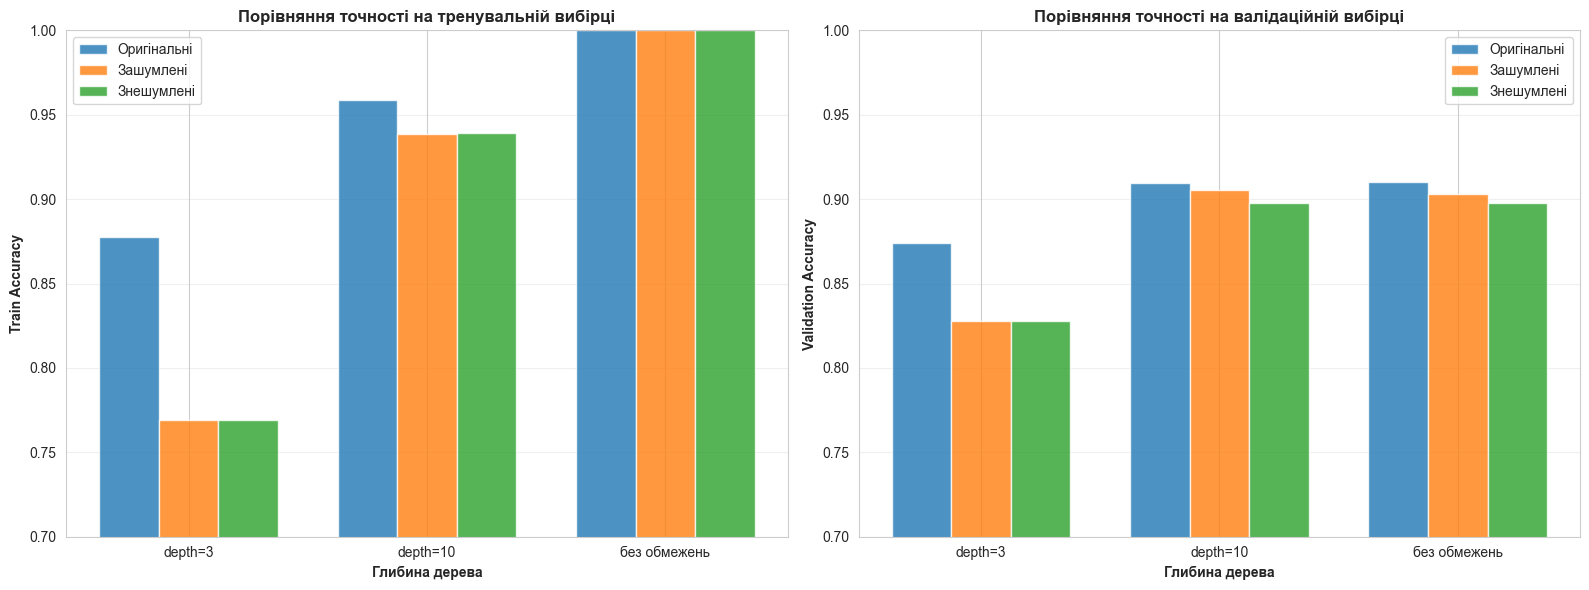

In [111]:
# Графік порівняння точності для всіх типів даних
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Підготовка даних
depths = ['depth=3', 'depth=10', 'без обмежень']
train_acc_original = [results['Дерево 1 (depth=3)']['train_accuracy'],
                      results['Дерево 2 (depth=10)']['train_accuracy'],
                      results['Дерево 3 (без обмежень)']['train_accuracy']]
val_acc_original = [results['Дерево 1 (depth=3)']['val_accuracy'],
                    results['Дерево 2 (depth=10)']['val_accuracy'],
                    results['Дерево 3 (без обмежень)']['val_accuracy']]

train_acc_noisy = [results_noisy['Дерево 1 (depth=3, noisy)']['train_accuracy'],
                   results_noisy['Дерево 2 (depth=10, noisy)']['train_accuracy'],
                   results_noisy['Дерево 3 (без обмежень, noisy)']['train_accuracy']]
val_acc_noisy = [results_noisy['Дерево 1 (depth=3, noisy)']['val_accuracy'],
                 results_noisy['Дерево 2 (depth=10, noisy)']['val_accuracy'],
                 results_noisy['Дерево 3 (без обмежень, noisy)']['val_accuracy']]

train_acc_denoised = [results_denoised['Дерево 1 (depth=3, denoised)']['train_accuracy'],
                      results_denoised['Дерево 2 (depth=10, denoised)']['train_accuracy'],
                      results_denoised['Дерево 3 (без обмежень, denoised)']['train_accuracy']]
val_acc_denoised = [results_denoised['Дерево 1 (depth=3, denoised)']['val_accuracy'],
                    results_denoised['Дерево 2 (depth=10, denoised)']['val_accuracy'],
                    results_denoised['Дерево 3 (без обмежень, denoised)']['val_accuracy']]

x = np.arange(len(depths))
width = 0.25

# Графік 1: Train Accuracy
axes[0].bar(x - width, train_acc_original, width, label='Оригінальні', alpha=0.8)
axes[0].bar(x, train_acc_noisy, width, label='Зашумлені', alpha=0.8)
axes[0].bar(x + width, train_acc_denoised, width, label='Знешумлені', alpha=0.8)
axes[0].set_xlabel('Глибина дерева', fontweight='bold')
axes[0].set_ylabel('Train Accuracy', fontweight='bold')
axes[0].set_title('Порівняння точності на тренувальній вибірці', fontweight='bold')
axes[0].set_xticks(x)
axes[0].set_xticklabels(depths)
axes[0].legend()
axes[0].grid(axis='y', alpha=0.3)
axes[0].set_ylim([0.7, 1.0])

# Графік 2: Validation Accuracy
axes[1].bar(x - width, val_acc_original, width, label='Оригінальні', alpha=0.8)
axes[1].bar(x, val_acc_noisy, width, label='Зашумлені', alpha=0.8)
axes[1].bar(x + width, val_acc_denoised, width, label='Знешумлені', alpha=0.8)
axes[1].set_xlabel('Глибина дерева', fontweight='bold')
axes[1].set_ylabel('Validation Accuracy', fontweight='bold')
axes[1].set_title('Порівняння точності на валідаційній вибірці', fontweight='bold')
axes[1].set_xticks(x)
axes[1].set_xticklabels(depths)
axes[1].legend()
axes[1].grid(axis='y', alpha=0.3)
axes[1].set_ylim([0.7, 1.0])

plt.tight_layout()
plt.show()

In [112]:
# Аналіз впливу шуму та знешумлення на точність
print("=" * 80)
print("АНАЛІЗ ВПЛИВУ ШУМУ ТА ЗНЕШУМЛЕННЯ")
print("=" * 80)

for depth_name in ['depth=3', 'depth=10', 'без обмежень']:
    print(f"\n{'='*80}")
    print(f"  {depth_name.upper()}")
    print(f"{'='*80}")
    
    # Знаходимо відповідні моделі
    if depth_name == 'depth=3':
        orig = results['Дерево 1 (depth=3)']
        noisy = results_noisy['Дерево 1 (depth=3, noisy)']
        denoised = results_denoised['Дерево 1 (depth=3, denoised)']
    elif depth_name == 'depth=10':
        orig = results['Дерево 2 (depth=10)']
        noisy = results_noisy['Дерево 2 (depth=10, noisy)']
        denoised = results_denoised['Дерево 2 (depth=10, denoised)']
    else:
        orig = results['Дерево 3 (без обмежень)']
        noisy = results_noisy['Дерево 3 (без обмежень, noisy)']
        denoised = results_denoised['Дерево 3 (без обмежень, denoised)']
    
    # Валідаційна точність
    print(f"\nВАЛІДАЦІЙНА ТОЧНІСТЬ:")
    print(f"  Оригінальні дані:    {orig['val_accuracy']:.4f} ({orig['val_accuracy']*100:.2f}%)")
    print(f"  Зашумлені дані:      {noisy['val_accuracy']:.4f} ({noisy['val_accuracy']*100:.2f}%)")
    print(f"  Знешумлені дані:     {denoised['val_accuracy']:.4f} ({denoised['val_accuracy']*100:.2f}%)")
    
    # Зміни точності
    drop_from_noise = (orig['val_accuracy'] - noisy['val_accuracy']) * 100
    recovery_from_denoising = (denoised['val_accuracy'] - noisy['val_accuracy']) * 100
    final_difference = (denoised['val_accuracy'] - orig['val_accuracy']) * 100
    
    print(f"\nЗМІНИ ТОЧНОСТІ:")
    print(f"  Втрата від шуму:           {drop_from_noise:+.2f}% (оригінальні → зашумлені)")
    print(f"  Покращення від PCA:        {recovery_from_denoising:+.2f}% (зашумлені → знешумлені)")
    print(f"  Підсумкова різниця:        {final_difference:+.2f}% (оригінальні → знешумлені)")
    
    # Overfitting
    print(f"\nOVERFITTING:")
    overfit_orig = (orig['train_accuracy'] - orig['val_accuracy']) * 100
    overfit_noisy = (noisy['train_accuracy'] - noisy['val_accuracy']) * 100
    overfit_denoised = (denoised['train_accuracy'] - denoised['val_accuracy']) * 100
    
    print(f"  Оригінальні:   {overfit_orig:.2f}%")
    print(f"  Зашумлені:     {overfit_noisy:.2f}%")
    print(f"  Знешумлені:    {overfit_denoised:.2f}%")

print("\n" + "=" * 80)

АНАЛІЗ ВПЛИВУ ШУМУ ТА ЗНЕШУМЛЕННЯ

  DEPTH=3

ВАЛІДАЦІЙНА ТОЧНІСТЬ:
  Оригінальні дані:    0.8737 (87.37%)
  Зашумлені дані:      0.8278 (82.78%)
  Знешумлені дані:     0.8278 (82.78%)

ЗМІНИ ТОЧНОСТІ:
  Втрата від шуму:           +4.60% (оригінальні → зашумлені)
  Покращення від PCA:        +0.00% (зашумлені → знешумлені)
  Підсумкова різниця:        -4.60% (оригінальні → знешумлені)

OVERFITTING:
  Оригінальні:   0.39%
  Зашумлені:     -5.85%
  Знешумлені:    -5.85%

  DEPTH=10

ВАЛІДАЦІЙНА ТОЧНІСТЬ:
  Оригінальні дані:    0.9096 (90.96%)
  Зашумлені дані:      0.9056 (90.56%)
  Знешумлені дані:     0.8975 (89.75%)

ЗМІНИ ТОЧНОСТІ:
  Втрата від шуму:           +0.40% (оригінальні → зашумлені)
  Покращення від PCA:        -0.81% (зашумлені → знешумлені)
  Підсумкова різниця:        -1.21% (оригінальні → знешумлені)

OVERFITTING:
  Оригінальні:   4.92%
  Зашумлені:     3.33%
  Знешумлені:    4.17%

  БЕЗ ОБМЕЖЕНЬ

ВАЛІДАЦІЙНА ТОЧНІСТЬ:
  Оригінальні дані:    0.9101 (91.01%)
  Зашумлені

## Частина 6. Тестування на тестовому наборі даних

Оцінимо фінальну точність всіх моделей на тестовому наборі даних.

In [113]:
# Тестування всіх моделей на тестовому наборі
print("=" * 100)
print("ТЕСТУВАННЯ НА ТЕСТОВОМУ НАБОРІ ДАНИХ")
print("=" * 100)

test_results = []

# 1. Тестування оригінальних моделей
print("\n" + "="*100)
print("ОРИГІНАЛЬНІ МОДЕЛІ")
print("="*100)

for name, res in results.items():
    y_test_pred = res['model'].predict(X_test)
    test_accuracy = accuracy_score(y_test, y_test_pred)
    
    depth_str = name.split('depth=')[1].split(')')[0] if 'depth=' in name else 'None'
    
    test_results.append({
        'Тип даних': 'Оригінальні',
        'Модель': name,
        'Max Depth': depth_str,
        'Train Acc': f"{res['train_accuracy']:.4f}",
        'Val Acc': f"{res['val_accuracy']:.4f}",
        'Test Acc': f"{test_accuracy:.4f}",
        'Test Acc %': f"{test_accuracy*100:.2f}%"
    })
    
    print(f"\n{name}")
    print(f"  Train: {res['train_accuracy']:.4f}, Val: {res['val_accuracy']:.4f}, Test: {test_accuracy:.4f}")

# 2. Тестування зашумлених моделей
print("\n" + "="*100)
print("ЗАШУМЛЕНІ МОДЕЛІ")
print("="*100)

for name, res in results_noisy.items():
    y_test_pred = res['model'].predict(X_test)
    test_accuracy = accuracy_score(y_test, y_test_pred)
    
    depth_str = name.split('depth=')[1].split(',')[0] if 'depth=' in name else 'None'
    
    test_results.append({
        'Тип даних': 'Зашумлені',
        'Модель': name,
        'Max Depth': depth_str,
        'Train Acc': f"{res['train_accuracy']:.4f}",
        'Val Acc': f"{res['val_accuracy']:.4f}",
        'Test Acc': f"{test_accuracy:.4f}",
        'Test Acc %': f"{test_accuracy*100:.2f}%"
    })
    
    print(f"\n{name}")
    print(f"  Train: {res['train_accuracy']:.4f}, Val: {res['val_accuracy']:.4f}, Test: {test_accuracy:.4f}")

# 3. Тестування знешумлених моделей
print("\n" + "="*100)
print("ЗНЕШУМЛЕНІ МОДЕЛІ (PCA)")
print("="*100)

for name, res in results_denoised.items():
    y_test_pred = res['model'].predict(X_test)
    test_accuracy = accuracy_score(y_test, y_test_pred)
    
    depth_str = name.split('depth=')[1].split(',')[0] if 'depth=' in name else 'None'
    
    test_results.append({
        'Тип даних': 'Знешумлені (PCA)',
        'Модель': name,
        'Max Depth': depth_str,
        'Train Acc': f"{res['train_accuracy']:.4f}",
        'Val Acc': f"{res['val_accuracy']:.4f}",
        'Test Acc': f"{test_accuracy:.4f}",
        'Test Acc %': f"{test_accuracy*100:.2f}%"
    })
    
    print(f"\n{name}")
    print(f"  Train: {res['train_accuracy']:.4f}, Val: {res['val_accuracy']:.4f}, Test: {test_accuracy:.4f}")

print("\n" + "="*100)

ТЕСТУВАННЯ НА ТЕСТОВОМУ НАБОРІ ДАНИХ

ОРИГІНАЛЬНІ МОДЕЛІ

Дерево 1 (depth=3)
  Train: 0.8776, Val: 0.8737, Test: 0.8732

Дерево 2 (depth=10)
  Train: 0.9588, Val: 0.9096, Test: 0.9051

Дерево 3 (без обмежень)
  Train: 1.0000, Val: 0.9101, Test: 0.9035

ЗАШУМЛЕНІ МОДЕЛІ

Дерево 1 (depth=3, noisy)
  Train: 0.7693, Val: 0.8278, Test: 0.8258

Дерево 2 (depth=10, noisy)
  Train: 0.9389, Val: 0.9056, Test: 0.8960

Дерево 3 (без обмежень, noisy)
  Train: 1.0000, Val: 0.9030, Test: 0.8929

ЗНЕШУМЛЕНІ МОДЕЛІ (PCA)

Дерево 1 (depth=3, denoised)
  Train: 0.7693, Val: 0.8278, Test: 0.8258

Дерево 2 (depth=10, denoised)
  Train: 0.9392, Val: 0.8975, Test: 0.8894

Дерево 3 (без обмежень, denoised)
  Train: 1.0000, Val: 0.8980, Test: 0.8859



In [114]:
# Порівняльна таблиця з тестовими результатами
test_results_df = pd.DataFrame(test_results)

print("\n" + "=" * 120)
print("ФІНАЛЬНА ТАБЛИЦЯ РЕЗУЛЬТАТІВ (TRAIN / VALIDATION / TEST)")
print("=" * 120)
print("\n")
print(test_results_df[['Тип даних', 'Max Depth', 'Train Acc', 'Val Acc', 'Test Acc']].to_string(index=False))


ФІНАЛЬНА ТАБЛИЦЯ РЕЗУЛЬТАТІВ (TRAIN / VALIDATION / TEST)


       Тип даних Max Depth Train Acc Val Acc Test Acc
     Оригінальні         3    0.8776  0.8737   0.8732
     Оригінальні        10    0.9588  0.9096   0.9051
     Оригінальні      None    1.0000  0.9101   0.9035
       Зашумлені         3    0.7693  0.8278   0.8258
       Зашумлені        10    0.9389  0.9056   0.8960
       Зашумлені      None    1.0000  0.9030   0.8929
Знешумлені (PCA)         3    0.7693  0.8278   0.8258
Знешумлені (PCA)        10    0.9392  0.8975   0.8894
Знешумлені (PCA)      None    1.0000  0.8980   0.8859


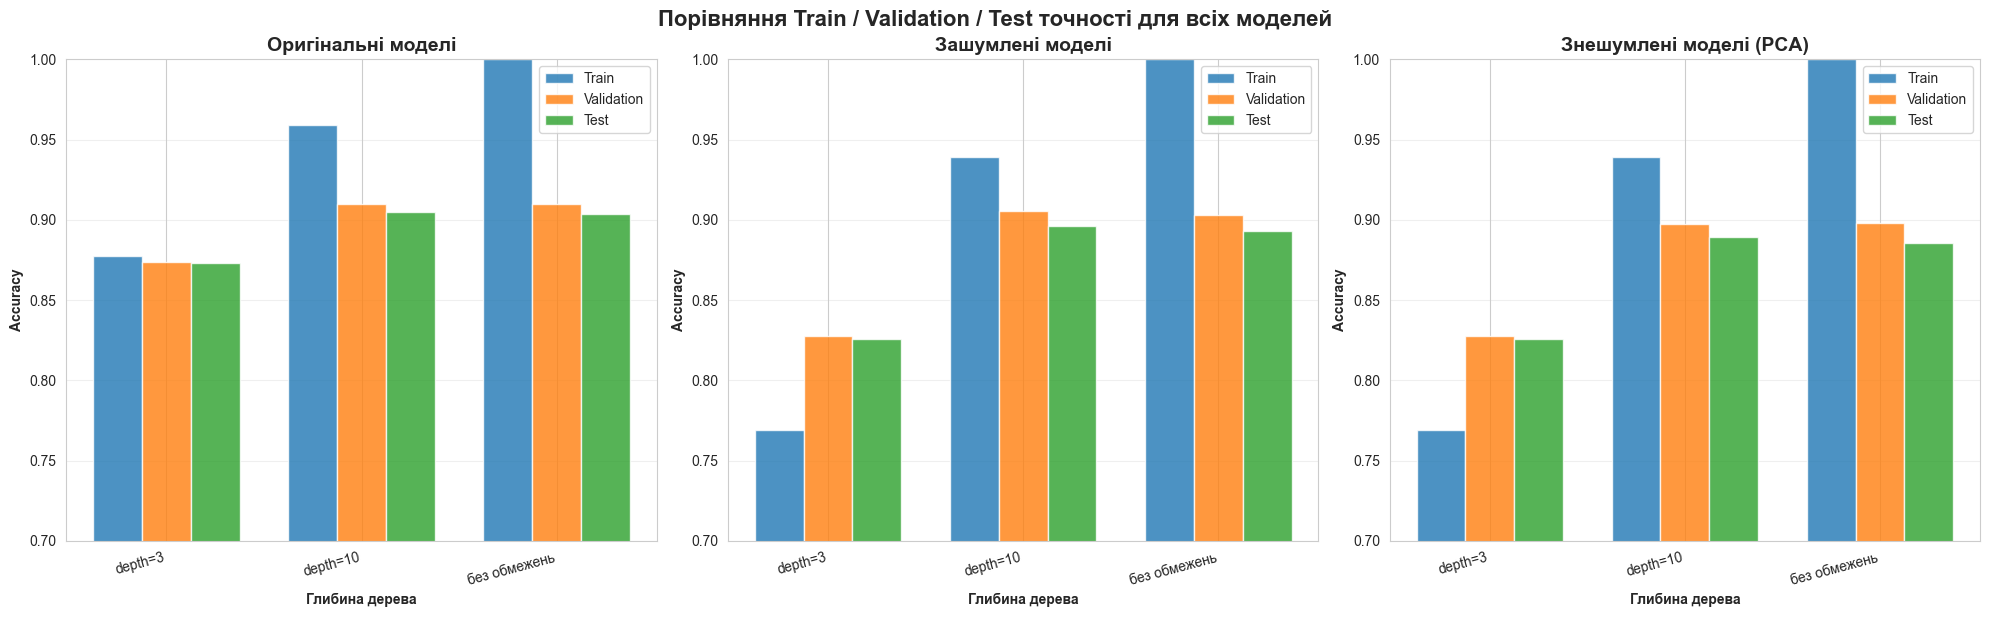

In [115]:
# Візуалізація тестових результатів
fig, axes = plt.subplots(1, 3, figsize=(20, 6))

depths = ['depth=3', 'depth=10', 'без обмежень']

# Збираємо дані для графіків
train_orig = [float(test_results_df[(test_results_df['Тип даних'] == 'Оригінальні') & 
                                     (test_results_df['Max Depth'] == d)]['Train Acc'].values[0]) 
              for d in ['3', '10', 'None']]
val_orig = [float(test_results_df[(test_results_df['Тип даних'] == 'Оригінальні') & 
                                   (test_results_df['Max Depth'] == d)]['Val Acc'].values[0]) 
            for d in ['3', '10', 'None']]
test_orig = [float(test_results_df[(test_results_df['Тип даних'] == 'Оригінальні') & 
                                    (test_results_df['Max Depth'] == d)]['Test Acc'].values[0]) 
             for d in ['3', '10', 'None']]

train_noisy = [float(test_results_df[(test_results_df['Тип даних'] == 'Зашумлені') & 
                                      (test_results_df['Max Depth'] == d)]['Train Acc'].values[0]) 
               for d in ['3', '10', 'None']]
val_noisy = [float(test_results_df[(test_results_df['Тип даних'] == 'Зашумлені') & 
                                    (test_results_df['Max Depth'] == d)]['Val Acc'].values[0]) 
             for d in ['3', '10', 'None']]
test_noisy = [float(test_results_df[(test_results_df['Тип даних'] == 'Зашумлені') & 
                                     (test_results_df['Max Depth'] == d)]['Test Acc'].values[0]) 
              for d in ['3', '10', 'None']]

train_denoised = [float(test_results_df[(test_results_df['Тип даних'] == 'Знешумлені (PCA)') & 
                                         (test_results_df['Max Depth'] == d)]['Train Acc'].values[0]) 
                  for d in ['3', '10', 'None']]
val_denoised = [float(test_results_df[(test_results_df['Тип даних'] == 'Знешумлені (PCA)') & 
                                       (test_results_df['Max Depth'] == d)]['Val Acc'].values[0]) 
                for d in ['3', '10', 'None']]
test_denoised = [float(test_results_df[(test_results_df['Тип даних'] == 'Знешумлені (PCA)') & 
                                        (test_results_df['Max Depth'] == d)]['Test Acc'].values[0]) 
                 for d in ['3', '10', 'None']]

x = np.arange(len(depths))
width = 0.25

# Графік 1: Оригінальні моделі
axes[0].bar(x - width, train_orig, width, label='Train', alpha=0.8)
axes[0].bar(x, val_orig, width, label='Validation', alpha=0.8)
axes[0].bar(x + width, test_orig, width, label='Test', alpha=0.8)
axes[0].set_xlabel('Глибина дерева', fontweight='bold')
axes[0].set_ylabel('Accuracy', fontweight='bold')
axes[0].set_title('Оригінальні моделі', fontweight='bold', fontsize=14)
axes[0].set_xticks(x)
axes[0].set_xticklabels(depths, rotation=15, ha='right')
axes[0].legend()
axes[0].grid(axis='y', alpha=0.3)
axes[0].set_ylim([0.7, 1.0])

# Графік 2: Зашумлені моделі
axes[1].bar(x - width, train_noisy, width, label='Train', alpha=0.8)
axes[1].bar(x, val_noisy, width, label='Validation', alpha=0.8)
axes[1].bar(x + width, test_noisy, width, label='Test', alpha=0.8)
axes[1].set_xlabel('Глибина дерева', fontweight='bold')
axes[1].set_ylabel('Accuracy', fontweight='bold')
axes[1].set_title('Зашумлені моделі', fontweight='bold', fontsize=14)
axes[1].set_xticks(x)
axes[1].set_xticklabels(depths, rotation=15, ha='right')
axes[1].legend()
axes[1].grid(axis='y', alpha=0.3)
axes[1].set_ylim([0.7, 1.0])

# Графік 3: Знешумлені моделі
axes[2].bar(x - width, train_denoised, width, label='Train', alpha=0.8)
axes[2].bar(x, val_denoised, width, label='Validation', alpha=0.8)
axes[2].bar(x + width, test_denoised, width, label='Test', alpha=0.8)
axes[2].set_xlabel('Глибина дерева', fontweight='bold')
axes[2].set_ylabel('Accuracy', fontweight='bold')
axes[2].set_title('Знешумлені моделі (PCA)', fontweight='bold', fontsize=14)
axes[2].set_xticks(x)
axes[2].set_xticklabels(depths, rotation=15, ha='right')
axes[2].legend()
axes[2].grid(axis='y', alpha=0.3)
axes[2].set_ylim([0.7, 1.0])

plt.tight_layout()
plt.suptitle('Порівняння Train / Validation / Test точності для всіх моделей', 
             fontsize=16, fontweight='bold', y=1.02)
plt.show()